In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Analysis functions

### Preprocessing

In [2]:
def get_bdp(xtopo: bool = False): 
    link_count = 3 if xtopo else 2
    outRate = 2 * 10**6 # 2 Mbps
    rtt = 5 * link_count * 2 * 10**-3 # 5ms one link, total return time is 20ms
    bdp = outRate * rtt / 8 # 2Mbps / 8b * 20ms = 5000B
    return bdp

def clean_colums(df, xtopo = False):
    bdp = get_bdp(xtopo)
    mtu = 1500
    df['queue_size'] = df['queue_size'].str.rstrip('B').astype(float)
    df['queue_size'] = df['queue_size'] / bdp
    df['burst'] = (df['burst'].astype(float) / mtu).astype(str) + "p"
    df['actual_rate_mbps'] = df['actual_rate'] / 1e6  # Convert to Mbps
    df['rate_mbps'] = df['rate'] / 1e6  # Convert to Mbps
    df['rx_rate_mbps'] = df['rx_rate'] / 1e6  # Convert to Mbps
    df['diff_mbps'] =  df['rate_mbps'] - df['rx_rate_mbps'] # df['rate_mbps'] - df['actual_rate_mbps']
    df['error_rate'] = df['diff_mbps'] / df['rx_rate_mbps']
    return df


### Plots

In [3]:
def plot_throughput(df, log=True, y_min=None, y_max=None, keep_fixed=True, title=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for burst, group in df.groupby('burst'):
        g = group.sort_values('queue_size')
        ax.plot(g['queue_size'], g['rx_rate_mbps'],
                marker='o', label=f'Burst {burst}')

    
    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Actual Rate (Mbps)')
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Actual Rate vs Queue Size for Different Burst Sizes')
    if log:
        ax.set_xscale('log')
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it

    fig.tight_layout()
    plt.show()


In [4]:
def plot_estimated_rate(df, log=True, y_min=None, y_max=None, keep_fixed=True, title=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    
    for burst, group in df.groupby('burst'):
        group_sorted = group.sort_values('queue_size')
        ax.plot(group_sorted['queue_size'], group_sorted['rate_mbps'],
                marker='o', label=f'Burst {burst}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Estimated Rate (Mbps)')
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Estimated rate vs Queue Size for Different Burst Sizes')
    if log:
        ax.set_xscale('log')  # Optional: log scale for wide range
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it

    
    fig.tight_layout()
    plt.show()

In [5]:
def plot_error_rate(df, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    for burst, group in df.groupby('burst'):
        group_sorted = group.sort_values('queue_size')
        ax.plot(group_sorted['queue_size'], group_sorted['error_rate'],
                marker='o', label=f'Burst {burst}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Error Rate')
    ax.set_title('Error Rate vs Queue Size for Different Burst Sizes')
    ax.set_xscale('log')  # Optional: log scale for wide range
    ax.grid(True, which='both', linestyle='--')
    ax.legend()
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it
    
    fig.tight_layout()
    plt.show()

In [6]:
def plot_throughput_difference(df, y_min=None, y_max=None, keep_fixed=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    for burst_val, grp in df.groupby('burst'):
        # sort by queue_size so lines connect in order
        grp = grp.sort_values('queue_size')
        ax.plot(grp['queue_size'], grp['diff_mbps'], marker='o', label=f'burst={int(burst_val)}')

    ax.set_xlabel('Queue Size (BDP)')
    ax.set_ylabel('Rate - Actual Rate (Mbps)')
    ax.set_title('Impact of Queue Size & Burst on Rate Difference')
    ax.set_xscale('log')  
    ax.grid(True, which='both', linestyle='--')
    ax.legend(title='Burst Size')
    
    if y_min is not None or y_max is not None:
        # current limits in case one side is left as None
        cur_low, cur_high = ax.get_ylim()
        low  = cur_low  if y_min is None else y_min
        high = cur_high if y_max is None else y_max
        ax.set_ylim(low, high)
        if keep_fixed:
            ax.autoscale(enable=False, axis='y')  # freeze it
    
    fig.tight_layout()
    plt.show()


In [7]:
def multiplot_throughput(dfs, titles, log=True, y_min=None, y_max=None, keep_fixed=True, nrows=2, ncols=3, figsize=(15,8), save_path=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # Flatten axes so we can index easily; if there's only one row or one column, ensure it's still iterable
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

    for idx, df in enumerate(dfs):
        ax = axes[idx]
        # Plot each 'burst' group on this Axes
        for burst, group in df.groupby('burst'):
            group_sorted = group.sort_values('queue_size')
            ax.plot(
                group_sorted['queue_size'],
                group_sorted['rx_rate_mbps'],
                marker='o',
                label=f"Burst {burst}"
            )

        ax.set_xlabel('Queue Size (BDP)')
        ax.set_ylabel('Estimated Rate (Mbps)')
        ax.set_title(titles[idx])
        if log:
            ax.set_xscale('log')
        ax.grid(True, which='both', linestyle='--')
        ax.legend()

        # If y‐limits are specified, fix them
        if (y_min is not None) or (y_max is not None):
            cur_low, cur_high = ax.get_ylim()
            low  = cur_low  if y_min is None else y_min
            high = cur_high if y_max is None else y_max
            ax.set_ylim(low, high)
            if keep_fixed:
                ax.autoscale(enable=False, axis='y')

    # Turn off any unused subplots
    for j in range(len(dfs), len(axes)):
        axes[j].axis('off')
        
    # Let tight_layout do its best…
    fig.tight_layout()

    # …but force a little extra vertical padding
    fig.subplots_adjust(hspace=0.35)  # ← increase 'hspace' to push rows apart

        
    # If save_path is provided, write the figure to disk before showing
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    fig.tight_layout()
    plt.show()

In [8]:
def multiplot_estimated_rate(dfs, titles, log=True, y_min=None, y_max=None, keep_fixed=True, nrows=2, ncols=3, figsize=(15,8), save_path=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # Flatten axes so we can index easily; if there's only one row or one column, ensure it's still iterable
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

    for idx, df in enumerate(dfs):
        ax = axes[idx]
        # Plot each 'burst' group on this Axes
        for burst, group in df.groupby('burst'):
            group_sorted = group.sort_values('queue_size')
            ax.plot(
                group_sorted['queue_size'],
                group_sorted['rate_mbps'],
                marker='o',
                label=f"Burst {burst}"
            )

        ax.set_xlabel('Queue Size (BDP)')
        ax.set_ylabel('Estimated Rate (Mbps)')
        ax.set_title(titles[idx])
        if log:
            ax.set_xscale('log')
        ax.grid(True, which='both', linestyle='--')
        ax.legend()

        # If y‐limits are specified, fix them
        if (y_min is not None) or (y_max is not None):
            cur_low, cur_high = ax.get_ylim()
            low  = cur_low  if y_min is None else y_min
            high = cur_high if y_max is None else y_max
            ax.set_ylim(low, high)
            if keep_fixed:
                ax.autoscale(enable=False, axis='y')

    # Turn off any unused subplots
    for j in range(len(dfs), len(axes)):
        axes[j].axis('off')
        
    # Let tight_layout do its best…
    fig.tight_layout()

    # …but force a little extra vertical padding
    fig.subplots_adjust(hspace=0.35)  # ← increase 'hspace' to push rows apart

        
    # If save_path is provided, write the figure to disk before showing
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    fig.tight_layout()
    plt.show()

## Simple topology

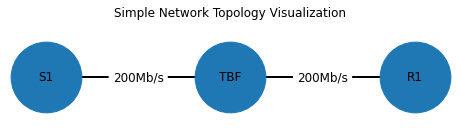

In [9]:
import networkx as nx

# Create the graph
G = nx.Graph()
edges = [
    ('n0', 'n2'),
    ('n2', 'n1'),
]
G.add_edges_from(edges)

# Define positions for a clear layout
pos = {
    'n0': (-1, -1),
    'n2': (1, -1),
    'n1': (0, -1),
}

# Draw nodes and edges
plt.figure(figsize=(8, 2))
nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, width=2)

# Custom labels to include Queue X and TBF
labels = {
    'n0': 'S1',
    'n1': 'TBF',
    'n2': 'R1',
}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

edge_labels = {
    ('n0', 'n1'): '200Mb/s',
    ('n2', 'n1'): '200Mb/s',
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.5)


# Remove axes for cleaner look
plt.axis('off')
plt.title('Simple Network Topology Visualization')
plt.savefig('figures/simple_topo.png', dpi=300, bbox_inches='tight')
plt.show()


# Shaping with constant packet size

In [10]:
file = "data/results_shaping.csv"
df_shaping = pd.read_csv(file)
# df_shaping['rx_rate']  = df_shaping['rx_rate'] * 1.33
df_shaping = clean_colums(df_shaping)
df_shaping = df_shaping[df_shaping['queue_size'] <= 5]
df_shaping = df_shaping[df_shaping['queue_size'] >= 0.5]

### Throughput (at Rx)

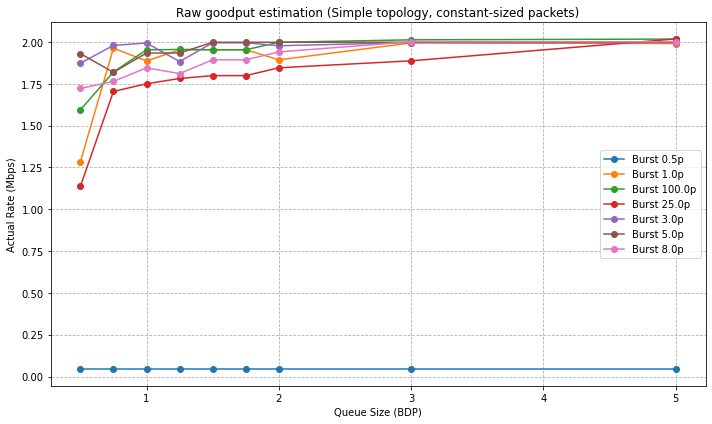

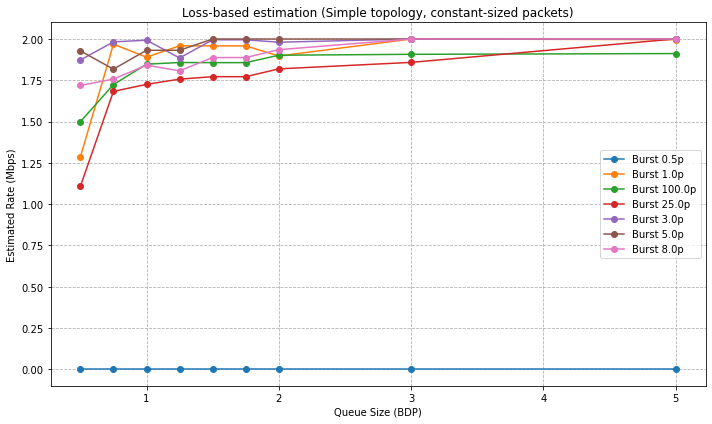

In [11]:
plot_throughput(df_shaping, log=False, title='Raw goodput estimation (Simple topology, constant-sized packets)')
plot_estimated_rate(df_shaping, log=False, title='Loss-based estimation (Simple topology, constant-sized packets)')

### Error rate

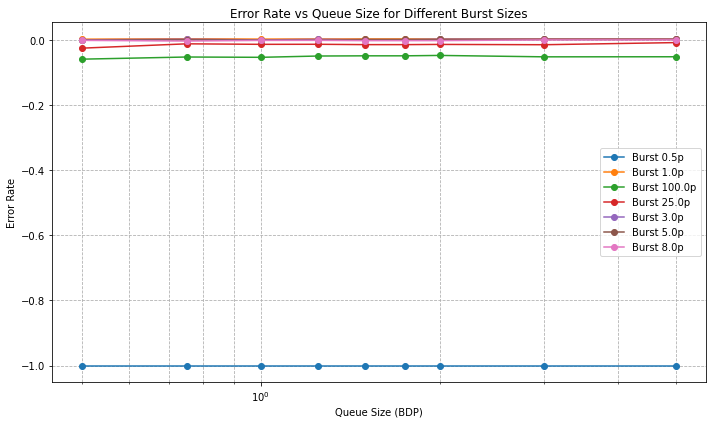

In [12]:
# temp_df = df[df['error_rate'] > -0.2]
plot_error_rate(df_shaping)

### Throughput difference

ValueError: invalid literal for int() with base 10: '0.5p'

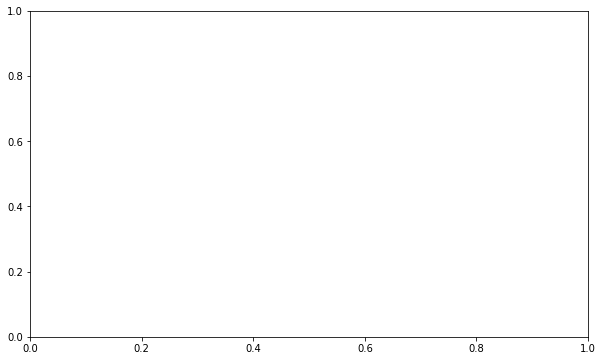

In [13]:
plot_throughput_difference(df_shaping)

# Shaping with variable packet size

In [14]:
file = "data/results_complex-shaping.csv"
df_shaping_variables = pd.read_csv(file)
df_shaping_variables['rx_rate']  = df_shaping_variables['rx_rate'] * 1.25
df_shaping_variables = clean_colums(df_shaping_variables)

### Actual rate and estimated rate

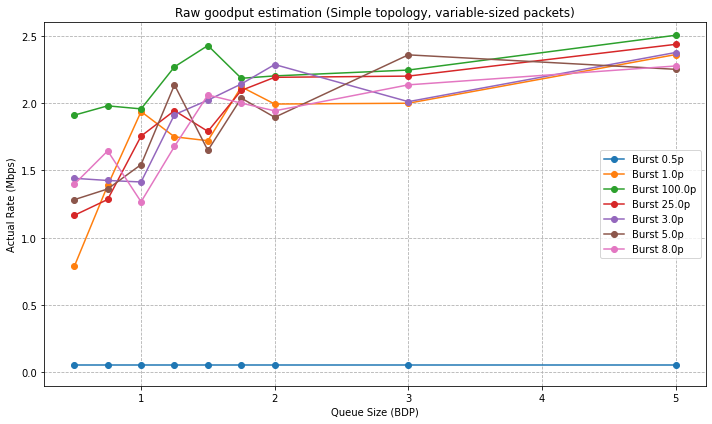

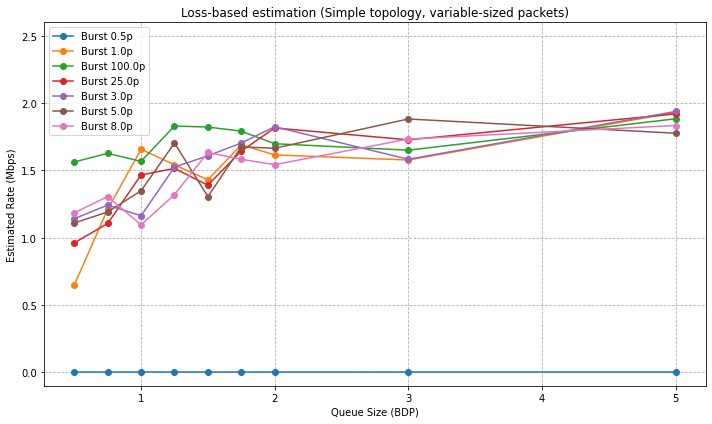

In [15]:
df_shaping_variables = df_shaping_variables[df_shaping_variables['queue_size'] <= 5]
df_shaping_variables = df_shaping_variables[df_shaping_variables['queue_size'] >= 0.5]

plot_throughput(df_shaping_variables, log=False, y_min=-0.1, y_max=2.6, title='Raw goodput estimation (Simple topology, variable-sized packets)')
plot_estimated_rate(df_shaping_variables, log=False, y_min=-0.1, y_max=2.6, title='Loss-based estimation (Simple topology, variable-sized packets)')

### Error rate (relative)

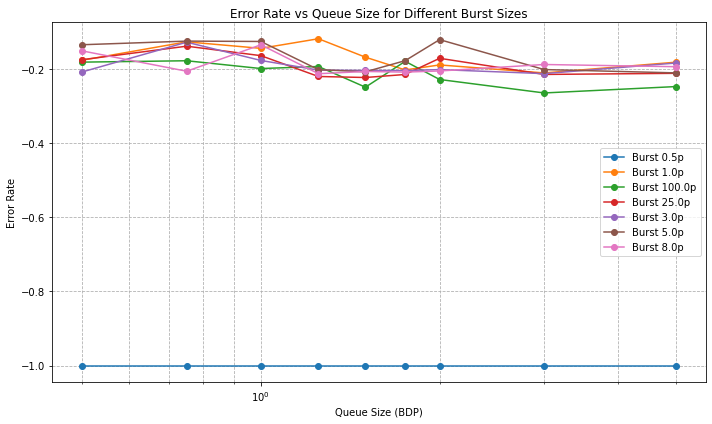

In [16]:
temp_df = df_shaping_variables[df_shaping_variables['error_rate'] > -0.2]
plot_error_rate(df_shaping_variables)

### Raw Difference 

ValueError: invalid literal for int() with base 10: '0.5p'

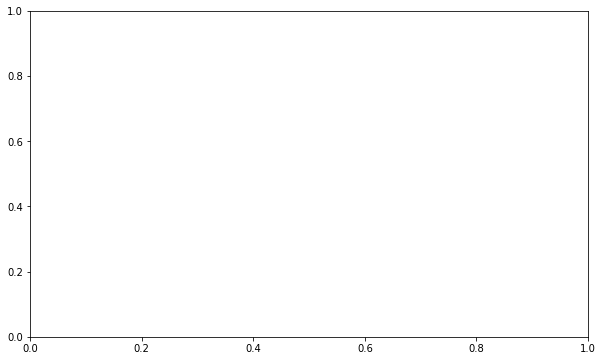

In [17]:
plot_throughput_difference(df_shaping_variables)

# X topology

It is following topology:

```
n4 -----|                   |----- n5
        |                   |
n0 -----n3 (Queue X) ------ n6 ------n1 (TBF)----- n2
   point-to-point links
```

n0 is the main server, n2 is the receiver. n0 sends variable size packets from 1B to 1448B (application layer size)

n4 is the background server, n5 is the background receiver. n4 sends constant size packets from BulkSend application.
n3 is configured as follows:

- burst: same burst as n1
- queue size: 1 packet
- out rate: 20Mbps 

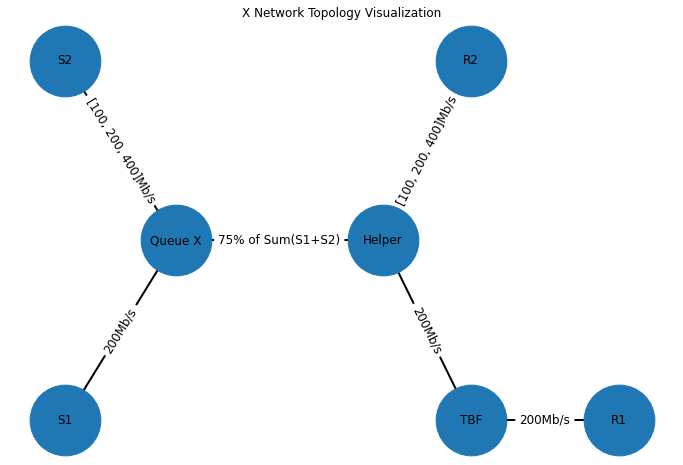

In [18]:
import networkx as nx

# Create the graph
G = nx.Graph()
edges = [
    ('n4', 'n3'),
    ('n5', 'n6'),
    ('n0', 'n3'),
    ('n3', 'n6'),
    ('n6', 'n1'),
    ('n1', 'n2'),
]
G.add_edges_from(edges)

# Define positions for a clear layout
pos = {
    'n3': (0,       0),
    'n0': (-0.75,   -0.3),
    'n1': (2,       -0.3),
    'n4': (-0.75,   0.3),
    'n5': (2,       0.3),
    'n2': (3,       -0.3),
    'n6': (1.4,     0),
}

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, width=2)

# Custom labels to include Queue X and TBF
labels = {
    'n0': 'S1',
    'n1': 'TBF',
    'n2': 'R1',
    'n3': 'Queue X',
    'n4': 'S2',
    'n5': 'R2',
    'n6': 'Helper',
}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

edge_labels = {
    ('n4', 'n3'): '[100, 200, 400]Mb/s',
    ('n5', 'n6'): '[100, 200, 400]Mb/s',
    ('n0', 'n3'): '200Mb/s',
    ('n3', 'n6'): '75% of Sum(S1+S2)',
    ('n6', 'n1'): '200Mb/s',
    ('n1', 'n2'): '200Mb/s',
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.5)


# Remove axes for cleaner look
plt.axis('off')
plt.title('X Network Topology Visualization')
plt.savefig('figures/xtopo.png', dpi=300, bbox_inches='tight')
plt.show()


### Goodput of Received data and Google paper estimated rate (Ratio 0.5:1)

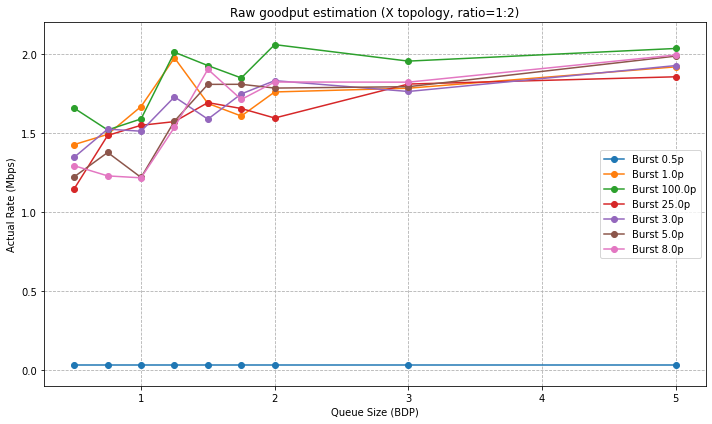

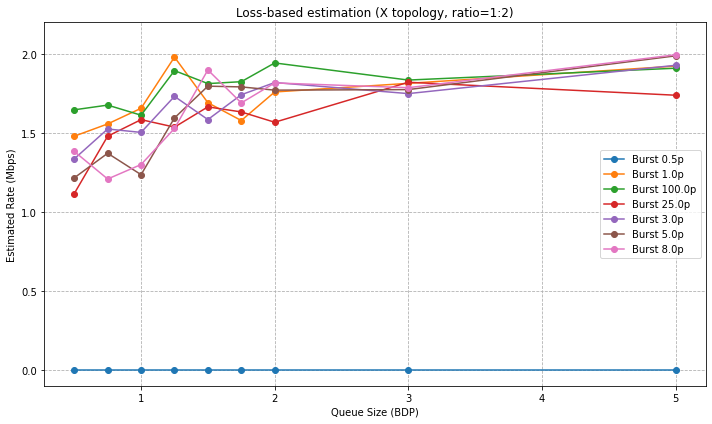

In [19]:
file = "data/results_xtopo-0.5_GOOGLE.csv"
df_xtopo_05 = pd.read_csv(file)
df_xtopo_05 = clean_colums(df_xtopo_05, xtopo=True)
df_xtopo_05 = df_xtopo_05[df_xtopo_05['queue_size'] <= 5]
df_xtopo_05 = df_xtopo_05[df_xtopo_05['queue_size'] >= 0.5]


plot_throughput(df_xtopo_05, log=False, y_min=-0.1, y_max=2.2, title='Raw goodput estimation (X topology, ratio=1:2)')
plot_estimated_rate(df_xtopo_05, log=False, y_min=-0.1, y_max=2.2, title='Loss-based estimation (X topology, ratio=1:2)')

### Goodput of Received data and Google paper estimated rate (Ratio 1:1)

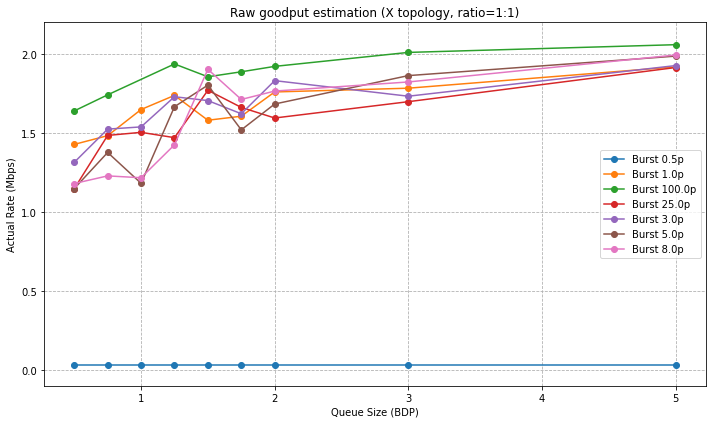

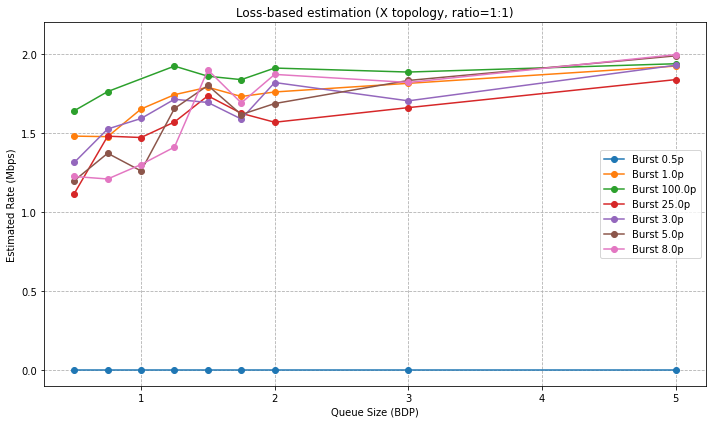

In [20]:
file = "data/results_xtopo-1.0_GOOGLE.csv"
df_xtopo_10 = pd.read_csv(file)
df_xtopo_10 = clean_colums(df_xtopo_10, xtopo=True)
df_xtopo_10 = df_xtopo_10[df_xtopo_10['queue_size'] <= 5]
df_xtopo_10 = df_xtopo_10[df_xtopo_10['queue_size'] >= 0.5]

plot_throughput(df_xtopo_10, log=False, y_min=-0.1, y_max=2.2, title='Raw goodput estimation (X topology, ratio=1:1)')
plot_estimated_rate(df_xtopo_10, log=False, y_min=-0.1, y_max=2.2, title='Loss-based estimation (X topology, ratio=1:1)')

### Goodput of Received data and Google paper estimated rate (Ratio 2:1)

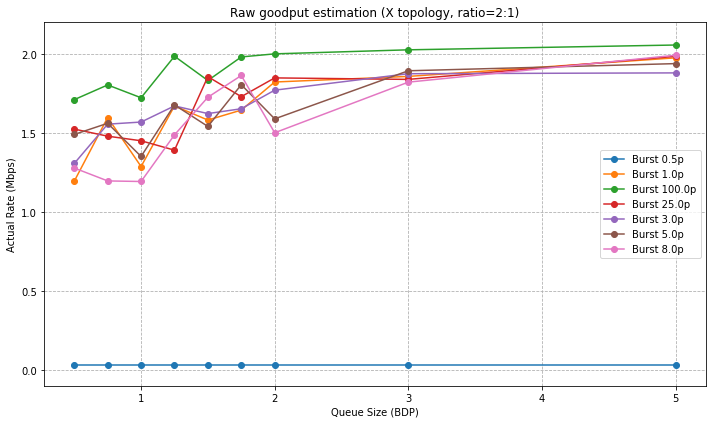

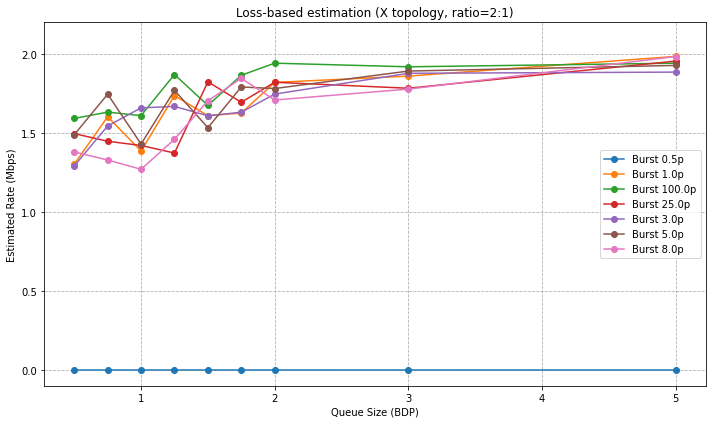

In [21]:
file = "data/results_xtopo-2.0_GOOGLE.csv"
df_xtopo_20 = pd.read_csv(file)
df_xtopo_20 = clean_colums(df_xtopo_20, xtopo=True)
df_xtopo_20 = df_xtopo_20[df_xtopo_20['queue_size'] <= 5]
df_xtopo_20 = df_xtopo_20[df_xtopo_20['queue_size'] >= 0.5]

plot_throughput(df_xtopo_20, log=False, y_min=-0.1, y_max=2.2, title='Raw goodput estimation (X topology, ratio=2:1)')
plot_estimated_rate(df_xtopo_20, log=False, y_min=-0.1, y_max=2.2, title='Loss-based estimation (X topology, ratio=2:1)')

Figure saved to: figures/estimated_rate_google.png


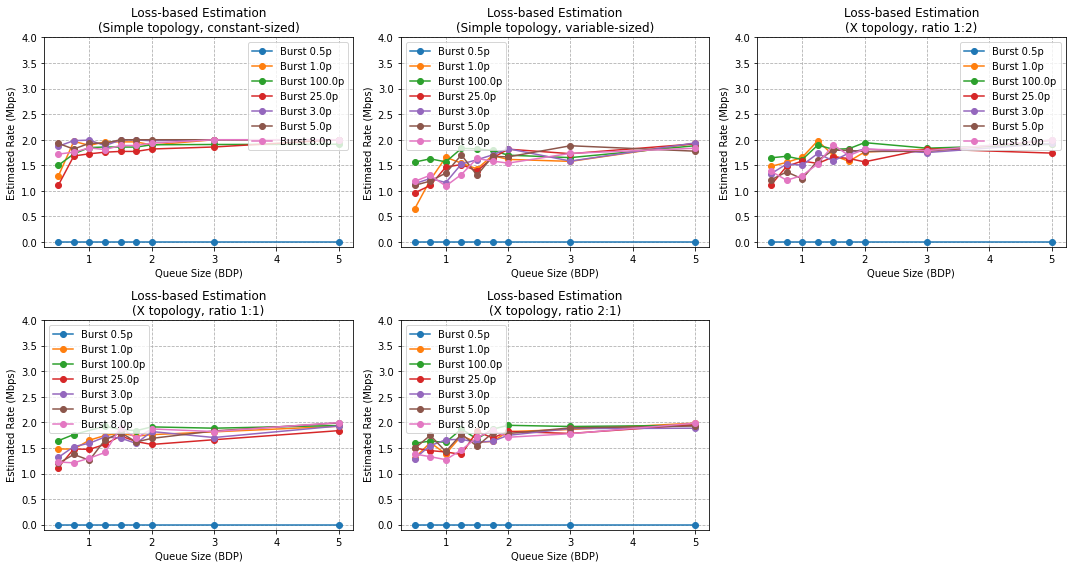

In [22]:
dfs = [
    df_shaping,
    df_shaping_variables,
    df_xtopo_05,
    df_xtopo_10,
    df_xtopo_20
]

titles = [
    'Loss-based Estimation\n(Simple topology, constant-sized)',
    'Loss-based Estimation\n(Simple topology, variable-sized)',
    'Loss-based Estimation\n(X topology, ratio 1:2)',
    'Loss-based Estimation\n(X topology, ratio 1:1)',
    'Loss-based Estimation\n(X topology, ratio 2:1)'
]

# Draw a 2×3 grid, leaving the 6th subplot empty
multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, log=False,save_path="figures/estimated_rate_google.png")

Figure saved to: figures/estimated_rate_goodput.png


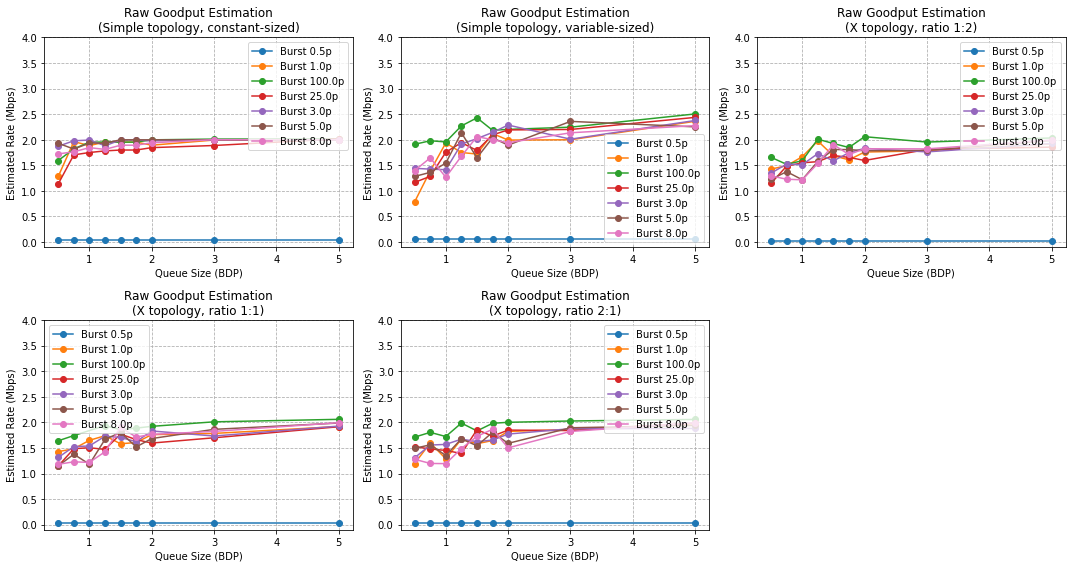

In [23]:
dfs = [
    df_shaping,
    df_shaping_variables,
    df_xtopo_05,
    df_xtopo_10,
    df_xtopo_20
]

titles = [
    'Raw Goodput Estimation\n(Simple topology, constant-sized)',
    'Raw Goodput Estimation\n(Simple topology, variable-sized)',
    'Raw Goodput Estimation\n(X topology, ratio 1:2)',
    'Raw Goodput Estimation\n(X topology, ratio 1:1)',
    'Raw Goodput Estimation\n(X topology, ratio 2:1)'
]

# Draw a 2×3 grid, leaving the 6th subplot empty
multiplot_throughput(dfs, titles, y_min=-0.1, y_max=4, log=False,save_path="figures/estimated_rate_goodput.png")

# Shaping with throughput between every pair of losses estimation algorithm

Algorithm:

```pseudocode
txs = []
last_loss_t = 0
sum = 0

for packet in packets:
    if packet not lost:
        sum += packet.size
    else:
        txs.append(sum / (packet.time - last_loss_t))
        last_loss_t = packet.time
        sum = 0

estimated_rate = sum(txs) / txs.size
```

### Constant Packet Size estimated rate

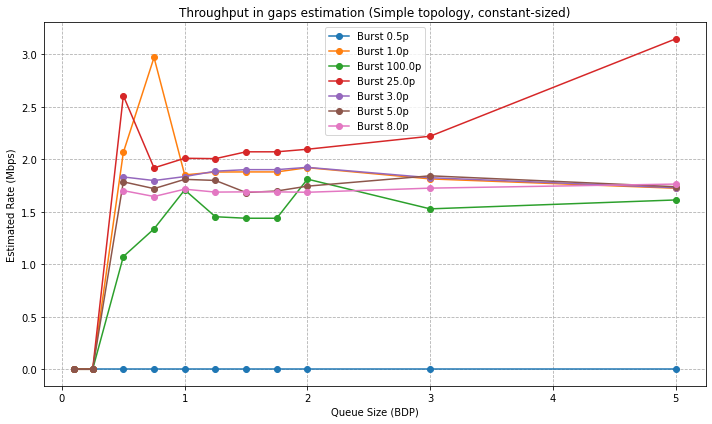

In [24]:
file = "data/results_shaping_TX_GAPS.csv"
df_gaps = pd.read_csv(file)
df_gaps = clean_colums(df_gaps)
df_gaps = df_gaps[df_gaps['queue_size'] <= 5]
plot_estimated_rate(df_gaps, log=False, title='Throughput in gaps estimation (Simple topology, constant-sized)')

### Variable Packet Size estimated rate

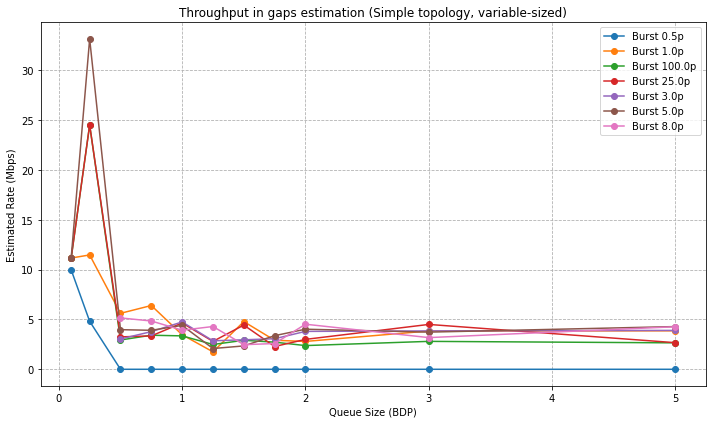

In [25]:
file = "data/results_complex-shaping_TX_GAPS.csv"
df_gaps_variable = pd.read_csv(file)
df_gaps_variable = clean_colums(df_gaps_variable)
df_gaps_variable = df_gaps_variable[df_gaps_variable['queue_size'] <= 5]
plot_estimated_rate(df_gaps_variable, log=False, title='Throughput in gaps estimation (Simple topology, variable-sized)')

### X topo ratio 0.5 estimated rate

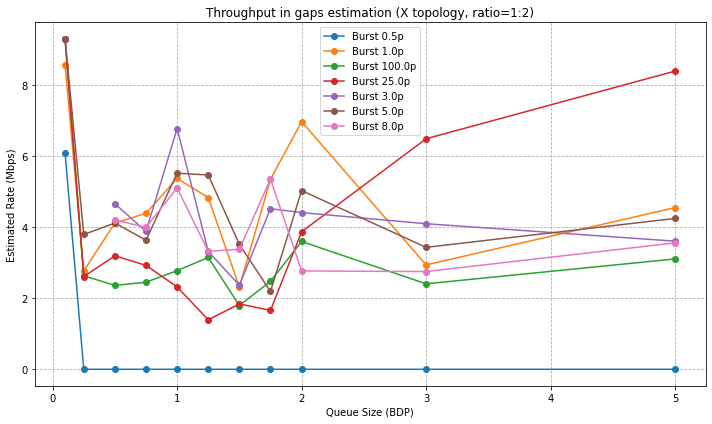

In [26]:
file = "data/results_xtopo-0.5_TX_GAPS.csv"
df_gaps_xtopo_05 = pd.read_csv(file)
df_gaps_xtopo_05 = clean_colums(df_gaps_xtopo_05, xtopo=True)
df_gaps_xtopo_05 = df_gaps_xtopo_05[df_gaps_xtopo_05['queue_size'] <= 5]
plot_estimated_rate(df_gaps_xtopo_05, log=False, title='Throughput in gaps estimation (X topology, ratio=1:2)')

### X topo ratio 1.0 estimated rate

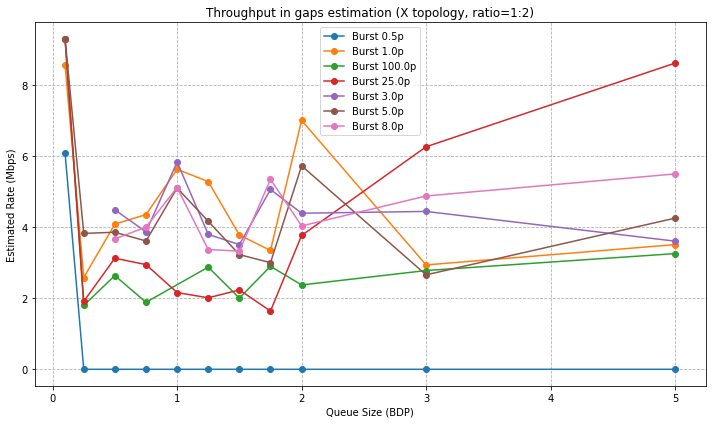

In [27]:
file = "data/results_xtopo-1.0_TX_GAPS.csv"
df_gaps_xtopo_10 = pd.read_csv(file)
df_gaps_xtopo_10 = clean_colums(df_gaps_xtopo_10, xtopo=True)
df_gaps_xtopo_10 = df_gaps_xtopo_10[df_gaps_xtopo_10['queue_size'] <= 5]
plot_estimated_rate(df_gaps_xtopo_10, log=False, title='Throughput in gaps estimation (X topology, ratio=1:2)')

### X topo ratio 2.0 estimated rate

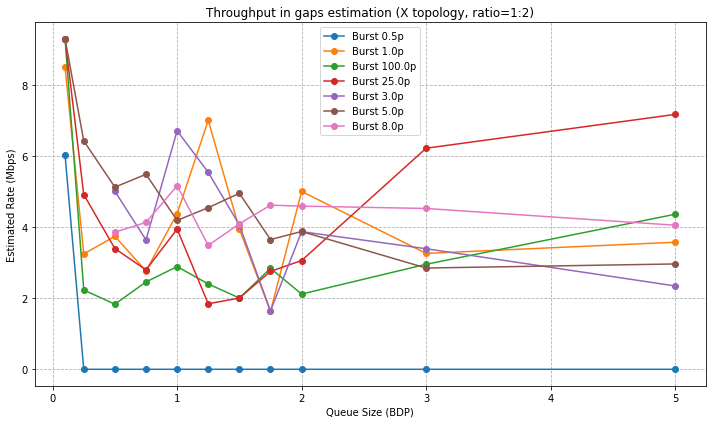

In [28]:
file = "data/results_xtopo-2.0_TX_GAPS.csv"
df_gaps_xtopo_20 = pd.read_csv(file)
df_gaps_xtopo_20 = clean_colums(df_gaps_xtopo_20, xtopo=True)
df_gaps_xtopo_20 = df_gaps_xtopo_20[df_gaps_xtopo_20['queue_size'] <= 5]
plot_estimated_rate(df_gaps_xtopo_20, log=False, title='Throughput in gaps estimation (X topology, ratio=1:2)')

# Shaping with throughput sampling algorithm

Algorithm:

```pseudocode
txs = []
sample_time = RTT
last_time = 0
next_time = sample_time
sum = 0

for packet in packets:
    if last_time <= packet.time < next_time:
        sum += packet.size
    else:
        txs.append(sum / sample_time)
        last_time = next_time
        next_time += sample_time
        sum_delivered = packet.size

estimated_rate = sum(txs) / txs.size
```

### Constant Packet Size estimated rate

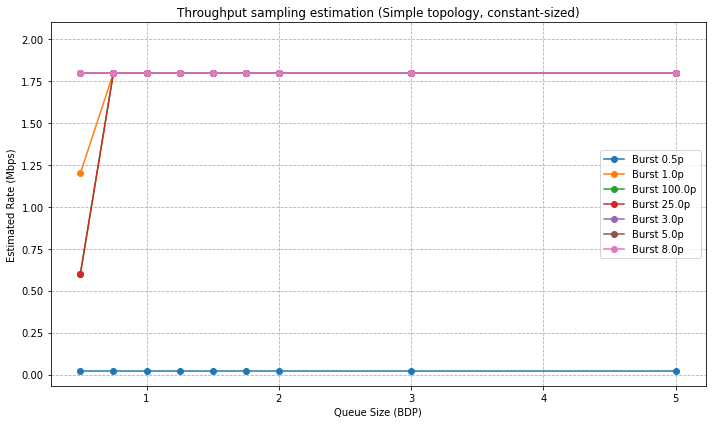

In [29]:
file = "data/results_shaping_TX_SAMPLE.csv"
df_custom_const = pd.read_csv(file)
df_custom_const = clean_colums(df_custom_const)
df_custom_const = df_custom_const[df_custom_const['queue_size'] <= 5]
df_custom_const = df_custom_const[df_custom_const['queue_size'] >= 0.5]
plot_estimated_rate(df_custom_const, y_max=2.1, log=False, title='Throughput sampling estimation (Simple topology, constant-sized)')

### Variable Packet Size estimated rate

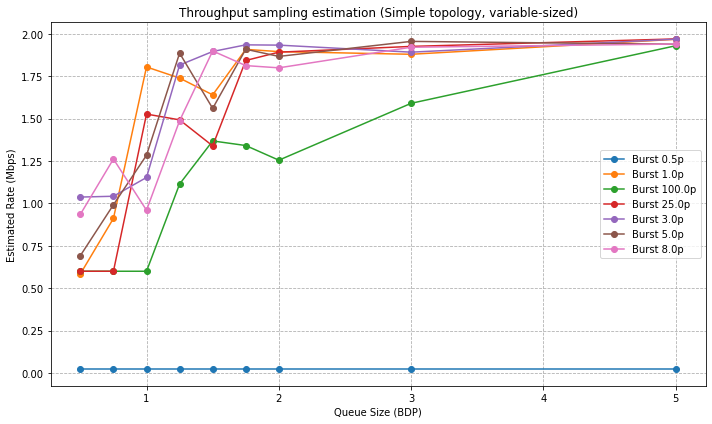

In [30]:
file = "data/results_complex-shaping_TX_SAMPLE.csv"
df_custom_var = pd.read_csv(file)
df_custom_var = clean_colums(df_custom_var)
df_custom_var = df_custom_var[df_custom_var['queue_size'] <= 5]
df_custom_var = df_custom_var[df_custom_var['queue_size'] >= 0.5]
plot_estimated_rate(df_custom_var, log=False, title='Throughput sampling estimation (Simple topology, variable-sized)')


### X topo ratio 0.5 estimated rate

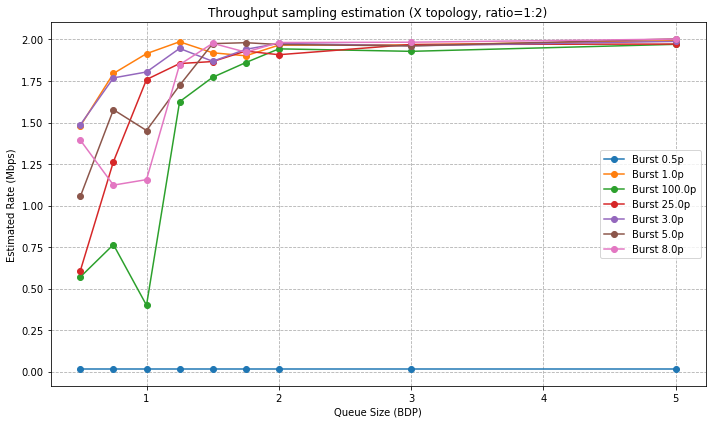

In [31]:
file = "data/results_xtopo-0.5_TX_SAMPLE.csv"
df_custom_xtopo_05 = pd.read_csv(file)
df_custom_xtopo_05 = clean_colums(df_custom_xtopo_05, xtopo=True)
df_custom_xtopo_05 = df_custom_xtopo_05[df_custom_xtopo_05['queue_size'] <= 5]
df_custom_xtopo_05 = df_custom_xtopo_05[df_custom_xtopo_05['queue_size'] >= 0.5]
plot_estimated_rate(df_custom_xtopo_05, log=False, title='Throughput sampling estimation (X topology, ratio=1:2)')

### X topo ratio 1.0 estimated rate

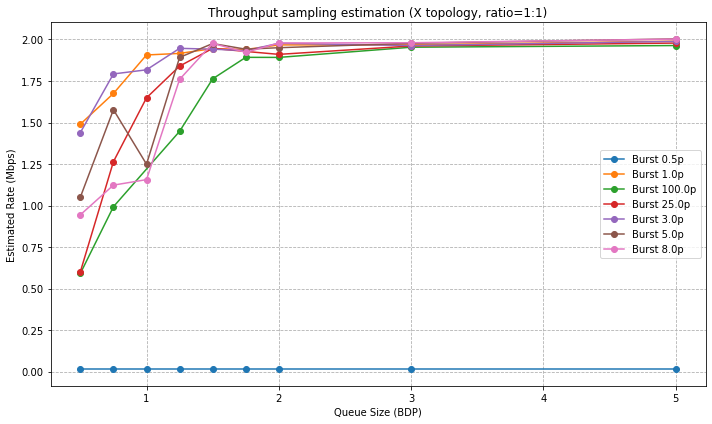

In [32]:
file = "data/results_xtopo-1.0_TX_SAMPLE.csv"
df_custom_xtopo_10 = pd.read_csv(file)
df_custom_xtopo_10 = clean_colums(df_custom_xtopo_10, xtopo=True)
df_custom_xtopo_10 = df_custom_xtopo_10[df_custom_xtopo_10['queue_size'] <= 5]
df_custom_xtopo_10 = df_custom_xtopo_10[df_custom_xtopo_10['queue_size'] >= 0.5]
plot_estimated_rate(df_custom_xtopo_10, log=False, title='Throughput sampling estimation (X topology, ratio=1:1)')

### X topo ratio 2.0 estimated rate

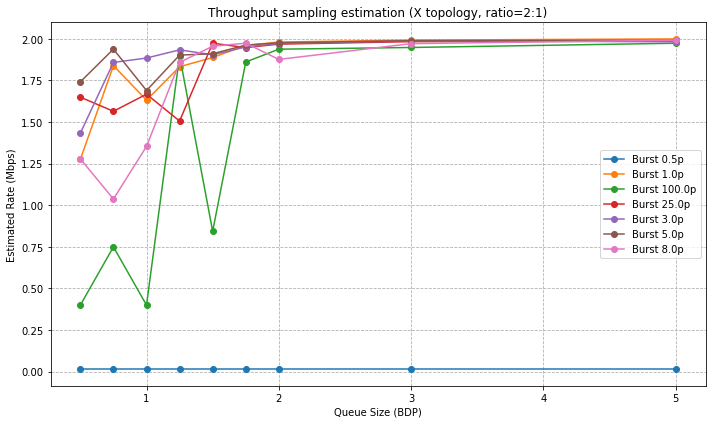

In [33]:
file = "data/results_xtopo-2.0_TX_SAMPLE.csv"
df_custom_xtopo_20 = pd.read_csv(file)
df_custom_xtopo_20 = clean_colums(df_custom_xtopo_20, xtopo=True)
df_custom_xtopo_20 = df_custom_xtopo_20[df_custom_xtopo_20['queue_size'] <= 5]
df_custom_xtopo_20 = df_custom_xtopo_20[df_custom_xtopo_20['queue_size'] >= 0.5]
plot_estimated_rate(df_custom_xtopo_20, log=False, title='Throughput sampling estimation (X topology, ratio=2:1)')

Figure saved to: figures/estimated_rate_tx_sample.png


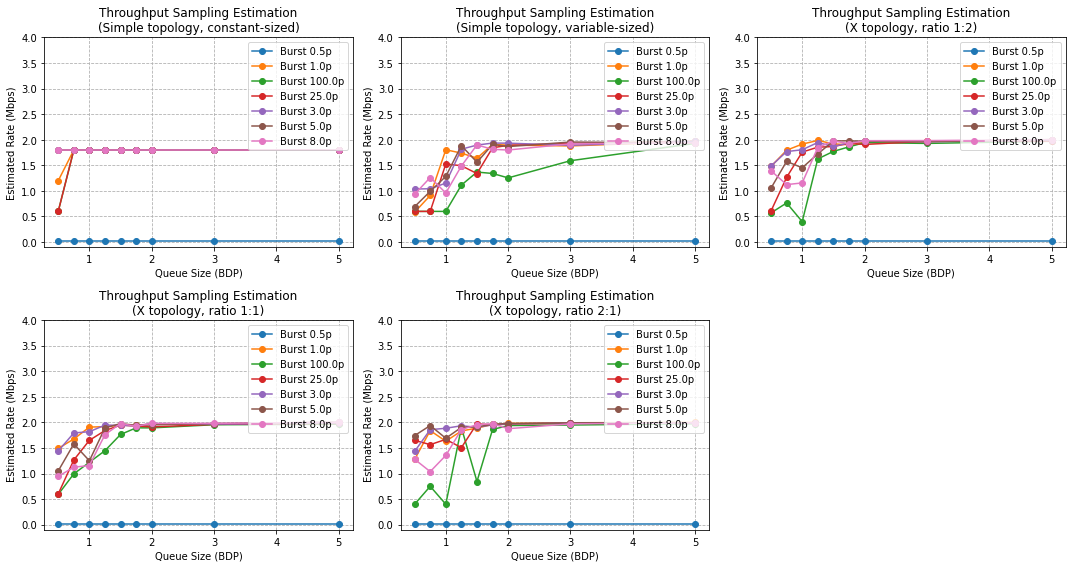

In [34]:
dfs = [
    df_custom_const,
    df_custom_var,
    df_custom_xtopo_05,
    df_custom_xtopo_10,
    df_custom_xtopo_20
]

titles = [
    'Throughput Sampling Estimation\n(Simple topology, constant-sized)',
    'Throughput Sampling Estimation\n(Simple topology, variable-sized)',
    'Throughput Sampling Estimation\n(X topology, ratio 1:2)',
    'Throughput Sampling Estimation\n(X topology, ratio 1:1)',
    'Throughput Sampling Estimation\n(X topology, ratio 2:1)'
]

# Draw a 2×3 grid, leaving the 6th subplot empty
multiplot_estimated_rate(dfs, titles,y_min=-0.1, y_max=4, log=False,save_path="figures/estimated_rate_tx_sample.png")

# CWND

In [35]:
file_cwnd = "data/wehe_cwnd_complex-shaping_37500_10000.0B_"
file_rtt = "data/wehe_rtt_complex-shaping_37500_10000.0B_"
file_rto = "data/wehe_rto_complex-shaping_37500_10000.0B_"
# file_cwnd = "data/wehe_cwnd_shaping_7500_5000.0B_"
# file_rtt = "data/wehe_rtt_shaping_7500_5000.0B_"
# file_rto = "data/wehe_rto_shaping_7500_5000.0B_"

cwnd = pd.read_csv(file_cwnd, header=None, names=['time', 'cwnd'])
rtt = pd.read_csv(file_rtt, header=None, names=['time', 'delay'])
rtt['used'] = 'rtt'
rto = pd.read_csv(file_rto, header=None, names=['time', 'delay'])
rto['used'] = 'rto'

delays = pd.concat([rtt, rto], ignore_index=True).sort_values('time')
cwnd = cwnd.sort_values('time')
merged = pd.merge_asof(cwnd, delays, on='time', direction='nearest')

merged['throughput'] = merged['cwnd'] / merged['delay']
merged['throughput'] = merged['throughput'] * 8 / 1e6  # Convert to Mbps

merged = merged.rename(columns={'delay': 'metric', 'used': 'source'})

print(merged.head())

       time   cwnd  metric source  throughput
0  0.120009  14480  1.0000    rto    0.115840
1  0.140136  15928  0.0225    rtt    5.663289
2  0.140226  17376  0.0225    rtt    6.178133
3  0.140281  18824  0.0225    rtt    6.692978
4  0.140368  20272  0.0225    rtt    7.207822


##### cwnd plot

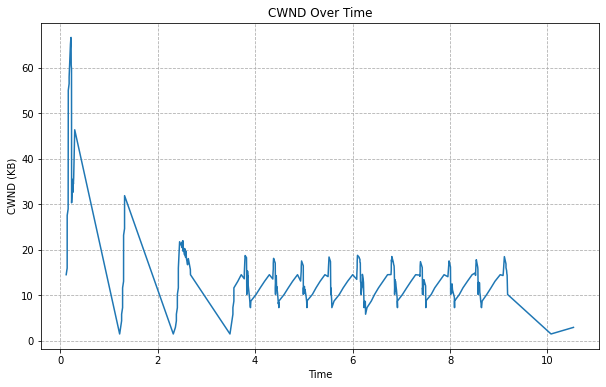

In [36]:
cwnd['cwnd'] = cwnd['cwnd'] / 1e3 # KB


plt.figure(figsize=(10, 6))
plt.plot(cwnd['time'], cwnd['cwnd'])
plt.xlabel('Time')
plt.ylabel('CWND (KB)')
plt.title('CWND Over Time')
plt.grid(True, which='both', linestyle='--')
plt.show()

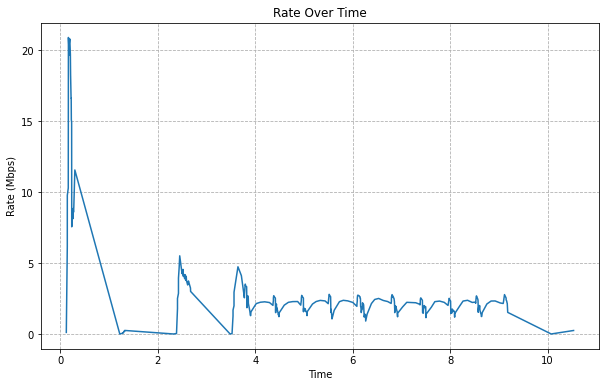

Average Rate: 3.19 Mbps
Min Rate: 0.01 Mbps


In [37]:
plt.figure(figsize=(10, 6))
# merged = merged[merged['time'] > 1]
plt.plot(merged['time'], merged['throughput'])
plt.xlabel('Time')
plt.ylabel('Rate (Mbps)')
plt.title('Rate Over Time')
plt.grid(True, which='both', linestyle='--')
plt.show()

average_rate = merged['throughput'].mean()
print(f"Average Rate: {average_rate:.2f} Mbps")
min_rate = merged['throughput'].min()
print(f"Min Rate: {min_rate:.2f} Mbps")

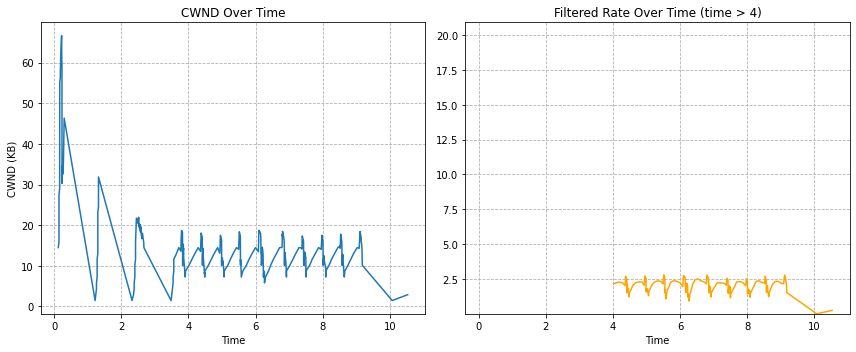

Average Rate: 2.12 Mbps
Min Rate: 0.01 Mbps


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Left plot: full DataFrame
axes[0].plot(cwnd['time'], cwnd['cwnd'], linestyle='-')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('CWND (KB)')
axes[0].set_title('CWND Over Time')
axes[0].grid(True, which='both', linestyle='--')

# Right plot: filtered DataFrame (time > 1.75)
filtered = merged[merged['time'] > 4]
axes[1].plot(filtered['time'], filtered['throughput'], linestyle='-', color='orange')
axes[1].set_xlabel('Time')
axes[1].set_title('Filtered Rate Over Time (time > 4)')
axes[1].grid(True, which='both', linestyle='--')
cur_low, cur_high = axes[1].get_ylim()
low  = merged['throughput'].min()
high = merged['throughput'].max()
axes[1].set_ylim(low, high)

plt.tight_layout()
plt.savefig('figures/cwnd_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute statistics on the full DataFrame
average_rate = filtered['throughput'].mean()
print(f"Average Rate: {average_rate:.2f} Mbps")
min_rate = merged['throughput'].min()
print(f"Min Rate: {min_rate:.2f} Mbps")

### Estimated rate with constant packet size

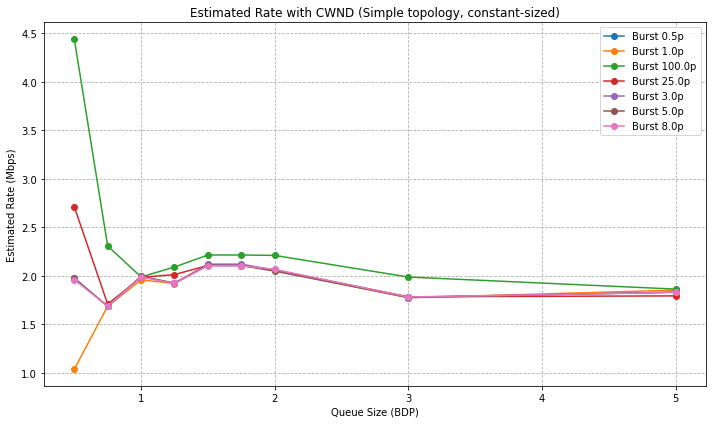

In [39]:
file = "data/results_shaping_CWND.csv"
df_cwnd_const = pd.read_csv(file)
df_cwnd_const = clean_colums(df_cwnd_const)
df_cwnd_const = df_cwnd_const[df_cwnd_const['queue_size'] <= 5]
df_cwnd_const = df_cwnd_const[df_cwnd_const['queue_size'] >= 0.5]
plot_estimated_rate(df_cwnd_const, log=False, title='Estimated Rate with CWND (Simple topology, constant-sized)')


### Estimated rate with variable packet size

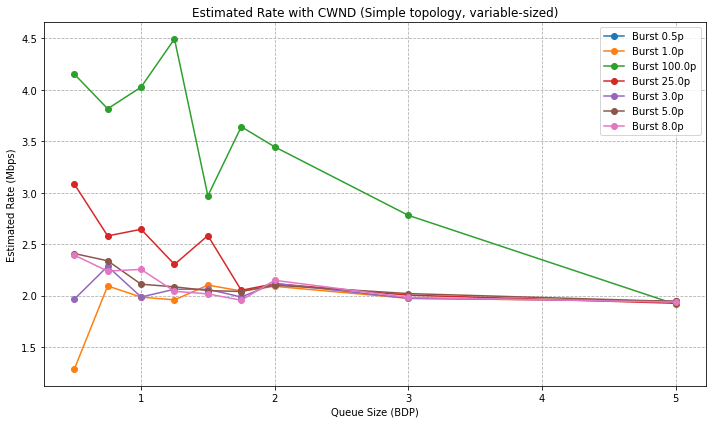

In [40]:
file = "data/results_complex-shaping_CWND.csv"
df_cwnd_var = pd.read_csv(file)
df_cwnd_var = clean_colums(df_cwnd_var)
df_cwnd_var = df_cwnd_var[df_cwnd_var['queue_size'] <= 5]
df_cwnd_var = df_cwnd_var[df_cwnd_var['queue_size'] >= 0.5]
plot_estimated_rate(df_cwnd_var, log=False, title='Estimated Rate with CWND (Simple topology, variable-sized)')

### X topo ratio 0.5 estimated rate

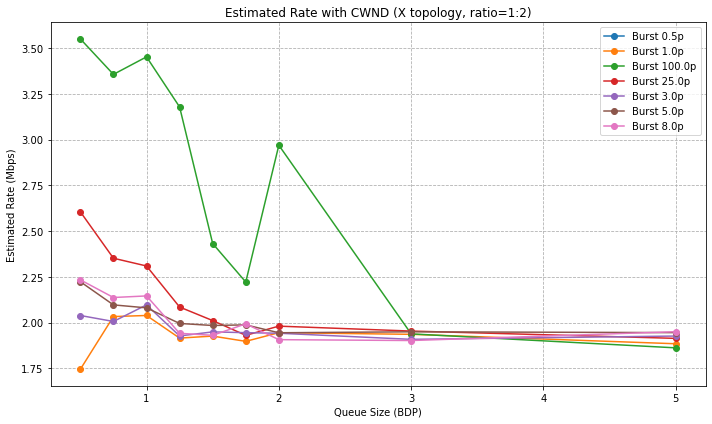

In [41]:
file = "data/results_xtopo-0.5_CWND.csv"
df_cwnd_xtopo_05 = pd.read_csv(file)
df_cwnd_xtopo_05 = clean_colums(df_cwnd_xtopo_05, xtopo=True)
df_cwnd_xtopo_05 = df_cwnd_xtopo_05[df_cwnd_xtopo_05['queue_size'] <= 5]
df_cwnd_xtopo_05 = df_cwnd_xtopo_05[df_cwnd_xtopo_05['queue_size'] >= 0.5]
plot_estimated_rate(df_cwnd_xtopo_05, log=False, title='Estimated Rate with CWND (X topology, ratio=1:2)')

### X topo ratio 1.0 estimated rate

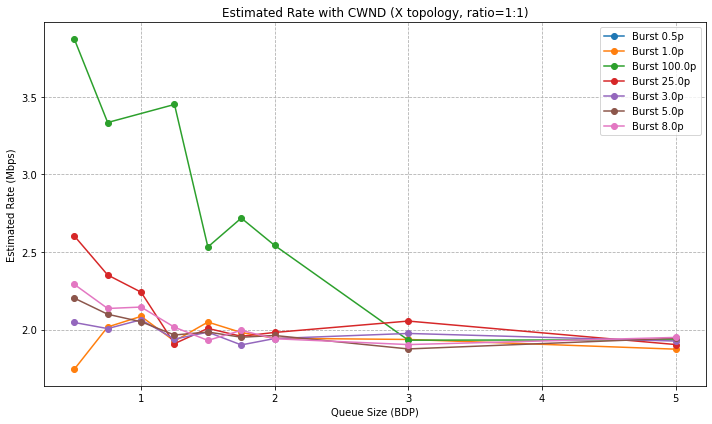

In [42]:
file = "data/results_xtopo-1.0_CWND.csv"
df_cwnd_xtopo_10 = pd.read_csv(file)
df_cwnd_xtopo_10 = clean_colums(df_cwnd_xtopo_10, xtopo=True)
df_cwnd_xtopo_10 = df_cwnd_xtopo_10[df_cwnd_xtopo_10['queue_size'] <= 5]
df_cwnd_xtopo_10 = df_cwnd_xtopo_10[df_cwnd_xtopo_10['queue_size'] >= 0.5]
plot_estimated_rate(df_cwnd_xtopo_10, log=False, title='Estimated Rate with CWND (X topology, ratio=1:1)')

### X topo ratio 2.0 estimated rate


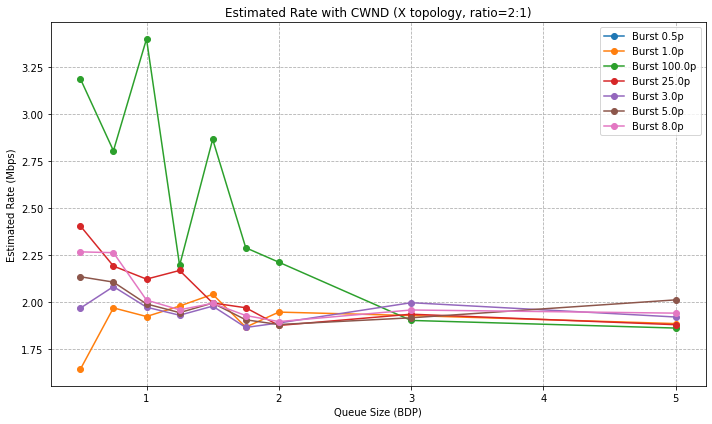

In [43]:
file = "data/results_xtopo-2.0_CWND.csv"
df_cwnd_xtopo_20 = pd.read_csv(file)
df_cwnd_xtopo_20 = clean_colums(df_cwnd_xtopo_20, xtopo=True)
df_cwnd_xtopo_20 = df_cwnd_xtopo_20[df_cwnd_xtopo_20['queue_size'] <= 5]
df_cwnd_xtopo_20 = df_cwnd_xtopo_20[df_cwnd_xtopo_20['queue_size'] >= 0.5]
plot_estimated_rate(df_cwnd_xtopo_20, log=False, title='Estimated Rate with CWND (X topology, ratio=2:1)')

### Multiplot

Figure saved to: figures/estimated_rate_cwnd.png


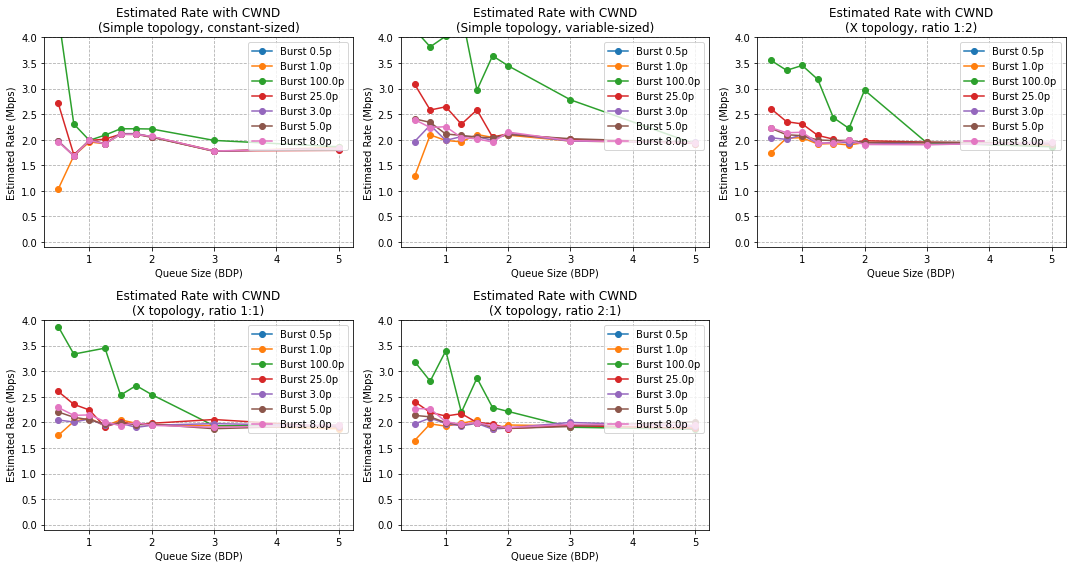

In [44]:
dfs = [
    df_cwnd_const,
    df_cwnd_var,
    df_cwnd_xtopo_05,
    df_cwnd_xtopo_10,
    df_cwnd_xtopo_20
]

titles = [
    'Estimated Rate with CWND\n(Simple topology, constant-sized)',
    'Estimated Rate with CWND\n(Simple topology, variable-sized)',
    'Estimated Rate with CWND\n(X topology, ratio 1:2)',
    'Estimated Rate with CWND\n(X topology, ratio 1:1)',
    'Estimated Rate with CWND\n(X topology, ratio 2:1)'
]

# Draw a 2×3 grid, leaving the 6th subplot empty
multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, log=False, save_path="figures/estimated_rate_cwnd.png")

# Client side rate estimation exploring

In [55]:
import experimentRun
CLIENT_IDENTIFIER = 'n0-n1-2-0.pcap'
EXPERIMENT = 2

experiment = 'shaping' if EXPERIMENT == 1 else 'complex-shaping' if EXPERIMENT == 2 else 'xtopo-2.00'
# name = "7500_5000.0B"
name = "150000_5000.0B"

# name = "7500_7500.0B"

In [56]:
params = name.split('_')
pcap = f"data/wehe_sim_{experiment}_{name}_{CLIENT_IDENTIFIER}"
run = experimentRun.ExperimentRun(name, pcap, pcap, "", params)
client = run.get_client_df()

## Cumulative arrival

In [57]:
client = client.sort_values(by='time').reset_index(drop=True)
client['cum_size'] = client['length'].cumsum()
client['cum_size'] = client['cum_size'] / 1e6 * 8  # Convert to Mb
rtt = run.get_rtt_on_client()
print("initial RTT:", rtt)

initial RTT: 0.020009


#### Derivative

In [58]:
# to properly estimate the tx, we should ignore the small diff values, where it spikes up a lot 
client['gap_time'] = client['time'].diff().fillna(0)
client['rate_b_per_s'] = client['cum_size'].diff() / client['gap_time']
client['rate_b_per_s'] = client['rate_b_per_s'].fillna(0)

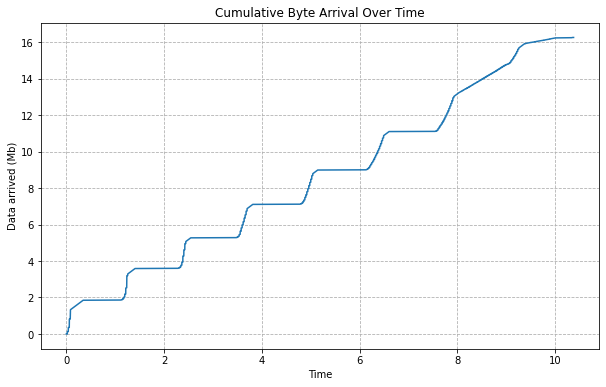

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(client['time'], client['cum_size'])
plt.xlabel('Time')
plt.ylabel('Data arrived (Mb)')
plt.title('Cumulative Byte Arrival Over Time')
plt.grid(True, which='both', linestyle='--')
plt.savefig("figures/cumulative_arrival.png", dpi=300, bbox_inches='tight')
plt.show()

estimated rate: 142.74636510061976
estimated rate: 197.33333333336262
2.016434334709677


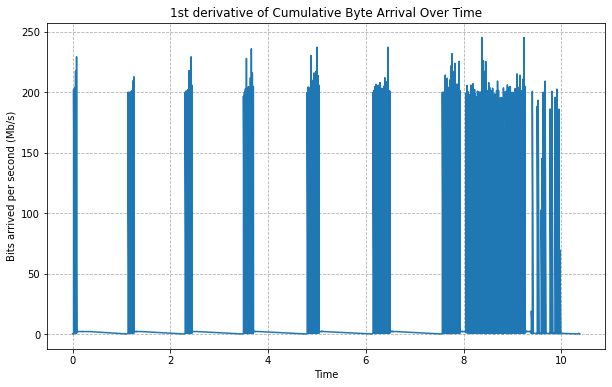

In [60]:
# CONSTANT_FILTER = 0.006  # 6 ms (prop delay after the TBF)
# res = client[client['gap_time'] > CONSTANT_FILTER]
# res = client[client['rate_b_per_s'] < 5]
res = client.copy()


print("estimated rate:", res['rate_b_per_s'].mean())
print("estimated rate:", res['rate_b_per_s'].median())

print(res['rate_b_per_s'].quantile(0.2))

plt.figure(figsize=(10, 6))
# client = client[client['time'] > 2]
plt.plot(res['time'], res['rate_b_per_s'])
plt.xlabel('Time')
plt.ylabel('Bits arrived per second (Mb/s)')
plt.title('1st derivative of Cumulative Byte Arrival Over Time')
plt.grid(True, which='both', linestyle='--')
plt.savefig("figures/cumulative_arrival_derivative.png", dpi=300, bbox_inches='tight')
plt.show()

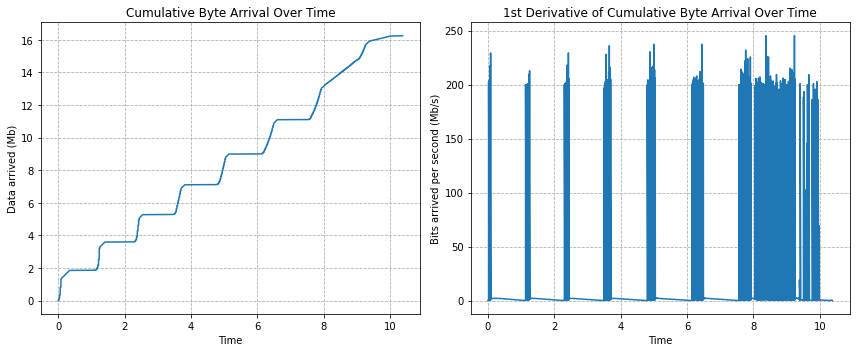

In [61]:
res = client.copy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# First subplot: cumulative arrival over time
ax1.plot(client['time'], client['cum_size'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Data arrived (Mb)')
ax1.set_title('Cumulative Byte Arrival Over Time')
ax1.grid(True, which='both', linestyle='--')

# Second subplot: 1st derivative (rate) over time
ax2.plot(res['time'], res['rate_b_per_s'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Bits arrived per second (Mb/s)')
ax2.set_title('1st Derivative of Cumulative Byte Arrival Over Time')
ax2.grid(True, which='both', linestyle='--')

# Adjust layout so titles/labels don’t overlap
fig.tight_layout()

# Save the combined figure
fig.savefig("figures/cumulative_arrival_combined_100p_1BDP.png", dpi=300, bbox_inches='tight')

# Display on screen
plt.show()

### Estimated rate for constant packet size

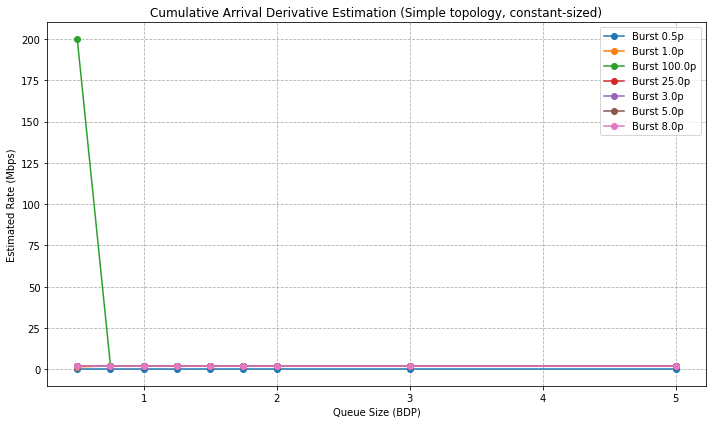

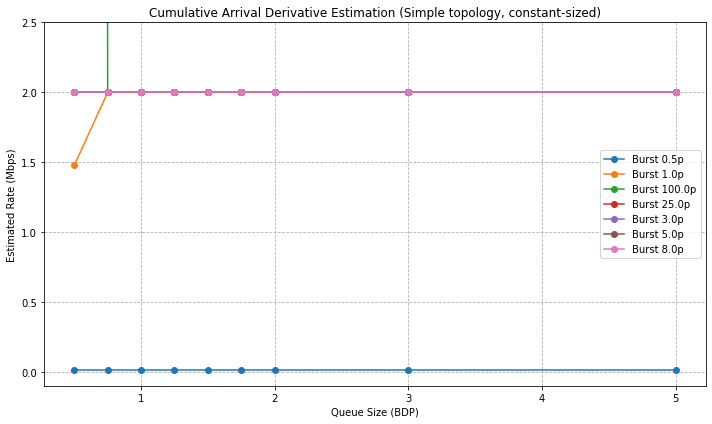

In [62]:
file = "data/results_shaping_CUMULATIVE.csv"
df_cum_const = pd.read_csv(file)
df_cum_const = clean_colums(df_cum_const)
df_cum_const = df_cum_const[df_cum_const['queue_size'] <= 5]
df_cum_const = df_cum_const[df_cum_const['queue_size'] >= 0.5]
plot_estimated_rate(df_cum_const, log=False, 
                    title='Cumulative Arrival Derivative Estimation (Simple topology, constant-sized)')

plot_estimated_rate(df_cum_const, log=False, 
                    title='Cumulative Arrival Derivative Estimation (Simple topology, constant-sized)', y_max=2.5, y_min=-0.1)

### Estimated rate for variable packet size

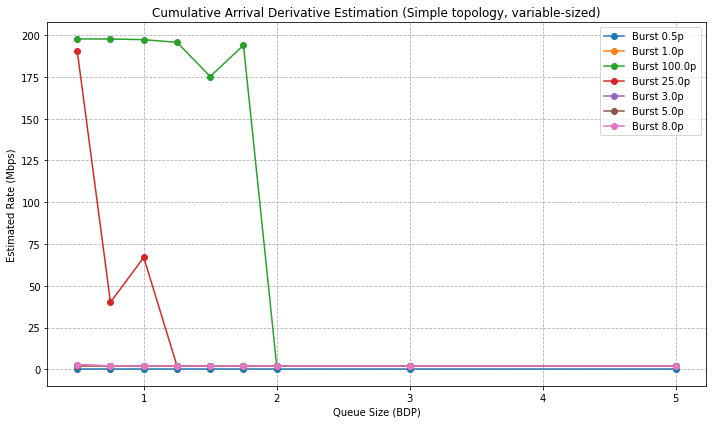

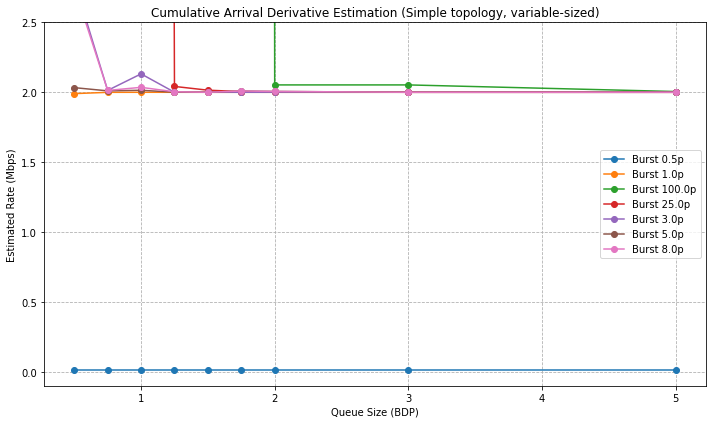

In [63]:
file = "data/results_complex-shaping_CUMULATIVE.csv"
df_cum_var = pd.read_csv(file)
df_cum_var = clean_colums(df_cum_var)
df_cum_var = df_cum_var[df_cum_var['queue_size'] <= 5]
df_cum_var = df_cum_var[df_cum_var['queue_size'] >= 0.5]

plot_estimated_rate(df_cum_var, log=False, title='Cumulative Arrival Derivative Estimation (Simple topology, variable-sized)')
plot_estimated_rate(df_cum_var, log=False, title='Cumulative Arrival Derivative Estimation (Simple topology, variable-sized)', y_max=2.5, y_min=-0.1)


### Estimated rate for X topology with traffic ratio 0.5

Measurement traffic to Queue X (and everywhere else): **200Mb/s**

Background traffic to Queue X (and everywhere else): **100Mb/s**

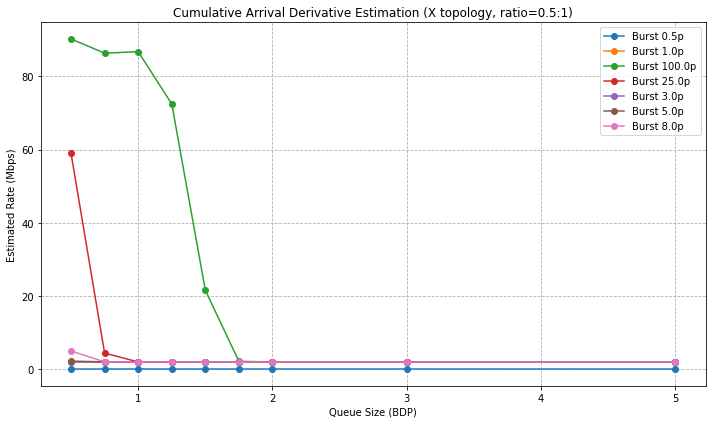

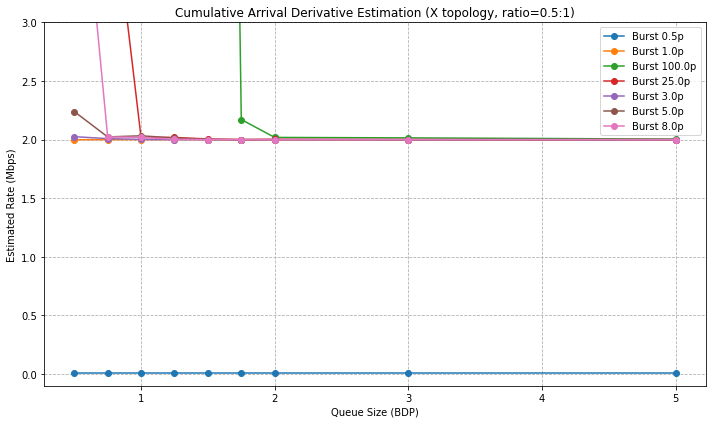

In [64]:
file = "data/results_xtopo-0.5_CUMULATIVE.csv"
df_cum_xtopo_05 = pd.read_csv(file)
df_cum_xtopo_05 = clean_colums(df_cum_xtopo_05, xtopo=True)
df_cum_xtopo_05 = df_cum_xtopo_05[df_cum_xtopo_05['queue_size'] <= 5]
df_cum_xtopo_05 = df_cum_xtopo_05[df_cum_xtopo_05['queue_size'] >= 0.5]

plot_estimated_rate(df_cum_xtopo_05, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=0.5:1)')
plot_estimated_rate(df_cum_xtopo_05, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=0.5:1)', y_max=3, y_min=-0.1)


### Estimated rate for X topology with traffic ratio 1.0

Measurement traffic to Queue X (and everywhere else): **200Mb/s**

Background traffic to Queue X (and everywhere else): **200Mb/s**

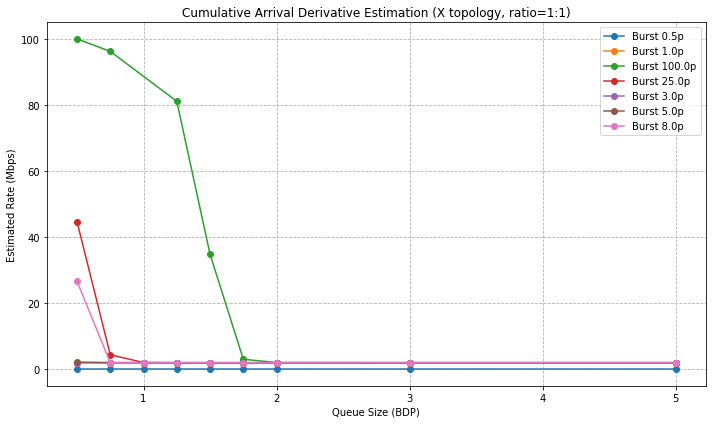

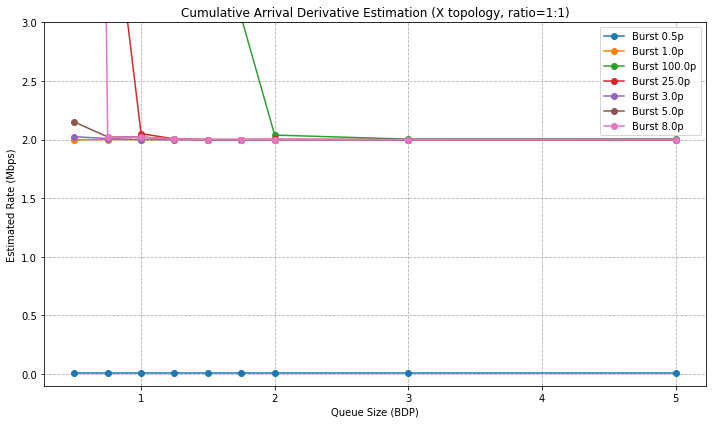

In [65]:
file = "data/results_xtopo-1.0_CUMULATIVE.csv"
df_cum_xtopo_10 = pd.read_csv(file)
df_cum_xtopo_10 = clean_colums(df_cum_xtopo_10, xtopo=True)
df_cum_xtopo_10 = df_cum_xtopo_10[df_cum_xtopo_10['queue_size'] <= 5]
df_cum_xtopo_10 = df_cum_xtopo_10[df_cum_xtopo_10['queue_size'] >= 0.5]

plot_estimated_rate(df_cum_xtopo_10, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=1:1)')
plot_estimated_rate(df_cum_xtopo_10, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=1:1)', y_max=3, y_min=-0.1)


### Estimated rate for X topology with traffic ratio 2.0

Measurement traffic to Queue X (and everywhere else): **200Mb/s**

Background traffic to Queue X (and everywhere else): **400Mb/s**

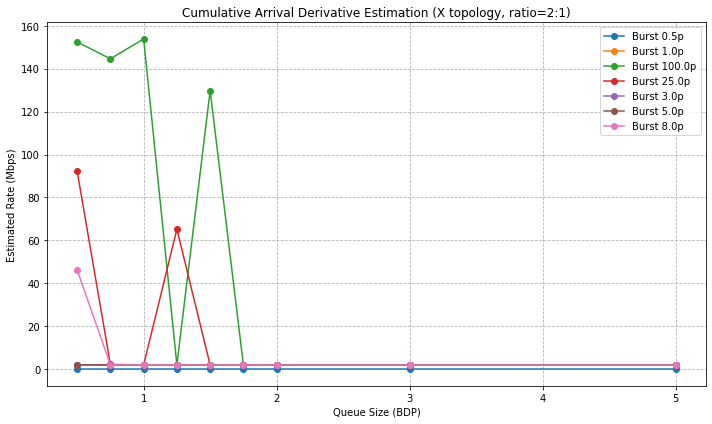

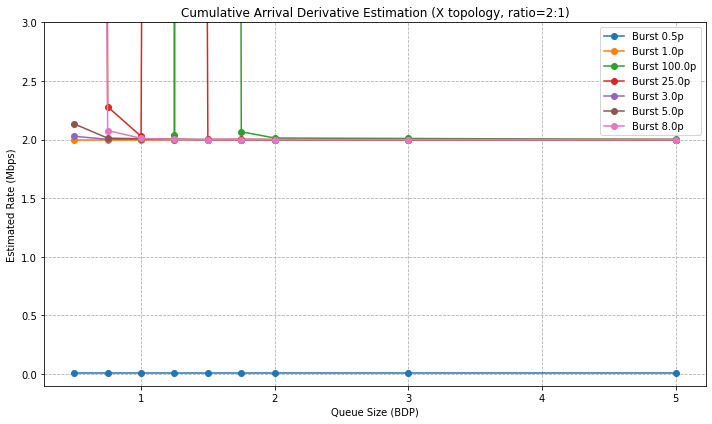

In [66]:
file = "data/results_xtopo-2.0_CUMULATIVE.csv"
df_cum_xtopo_20 = pd.read_csv(file)
df_cum_xtopo_20 = clean_colums(df_cum_xtopo_20, xtopo=True)
df_cum_xtopo_20 = df_cum_xtopo_20[df_cum_xtopo_20['queue_size'] >= 0.5]
df_cum_xtopo_20 = df_cum_xtopo_20[df_cum_xtopo_20['queue_size'] <= 5]
plot_estimated_rate(df_cum_xtopo_20, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=2:1)')
plot_estimated_rate(df_cum_xtopo_20, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=2:1)', y_max=3, y_min=-0.1)


Figure saved to: figures/estimated_rate_cumulative.png


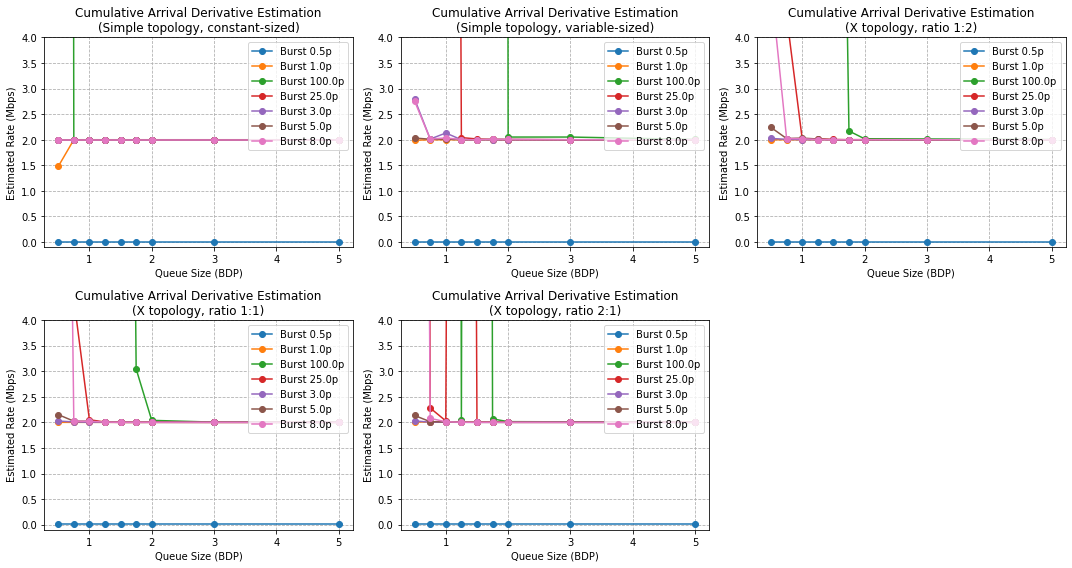

In [67]:
dfs = [
    df_cum_const,
    df_cum_var,
    df_cum_xtopo_05,
    df_cum_xtopo_10,
    df_cum_xtopo_20
]

titles = [
    'Cumulative Arrival Derivative Estimation\n(Simple topology, constant-sized)',
    'Cumulative Arrival Derivative Estimation\n(Simple topology, variable-sized)',
    'Cumulative Arrival Derivative Estimation\n(X topology, ratio 1:2)',
    'Cumulative Arrival Derivative Estimation\n(X topology, ratio 1:1)',
    'Cumulative Arrival Derivative Estimation\n(X topology, ratio 2:1)'
]

# Draw a 2×3 grid, leaving the 6th subplot empty
multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, log=False,save_path="figures/estimated_rate_cumulative.png")

- find realistic burst sizes (google paper, wehe, zeinab's paper). Describe realistic scenarios where the burst lengths make sense.

- discussion: bursty traffic and pros and cons of the estimations.

- include the bursty traffic in the report


- for presentation - 0. docker compilation 1. run tcp reno (ratio=2:1, simple w/ variable packets), 2. run 3 & 8p V 3. 1p queue size

present the components that were tested of the deployement.


## TCP NewReno effect on the estimations

### Cumulative

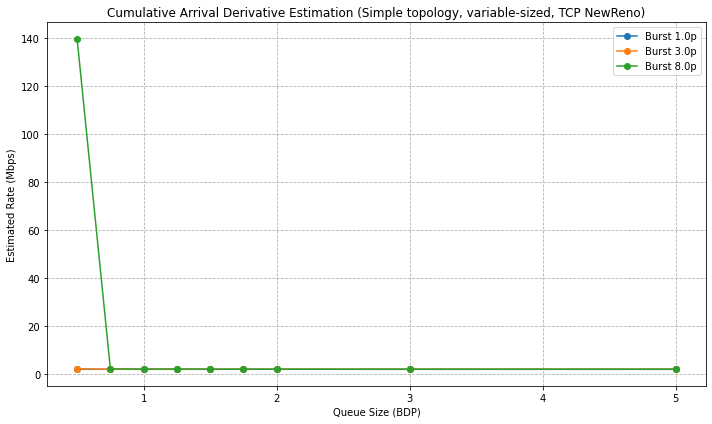

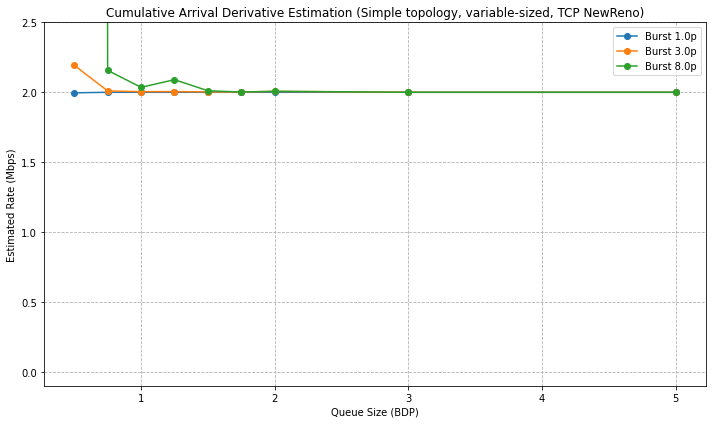

In [68]:
file = "data/results_reno-complex-shaping_CUMULATIVE.csv"
df_reno_cum_var = pd.read_csv(file)
df_reno_cum_var = clean_colums(df_reno_cum_var)
df_reno_cum_var = df_reno_cum_var[df_reno_cum_var['queue_size'] <= 5]
df_reno_cum_var = df_reno_cum_var[df_reno_cum_var['queue_size'] >= 0.5]

plot_estimated_rate(df_reno_cum_var, log=False, title='Cumulative Arrival Derivative Estimation (Simple topology, variable-sized, TCP NewReno)')
plot_estimated_rate(df_reno_cum_var, log=False, title='Cumulative Arrival Derivative Estimation (Simple topology, variable-sized, TCP NewReno)', y_max=2.5, y_min=-0.1)

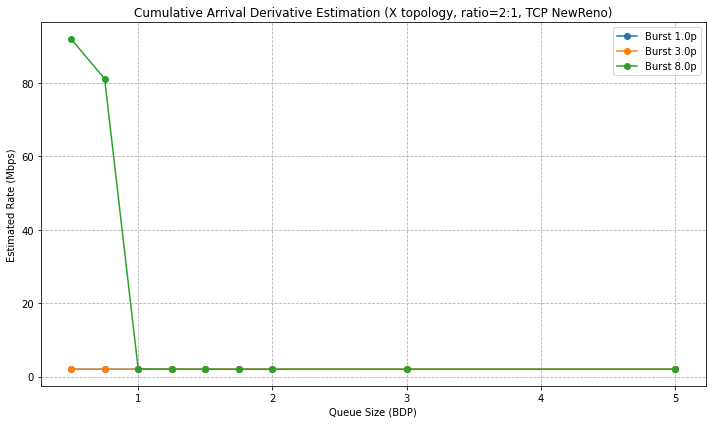

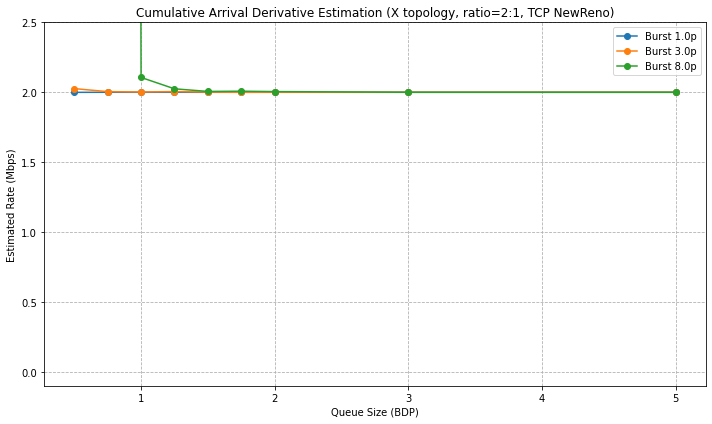

In [69]:
file = "data/results_reno-xtopo_CUMULATIVE.csv"
df_reno_cum_xtopo_20 = pd.read_csv(file)
df_reno_cum_xtopo_20 = clean_colums(df_reno_cum_xtopo_20, xtopo=True)
df_reno_cum_xtopo_20 = df_reno_cum_xtopo_20[df_reno_cum_xtopo_20['queue_size'] >= 0.5]
df_reno_cum_xtopo_20 = df_reno_cum_xtopo_20[df_reno_cum_xtopo_20['queue_size'] <= 5]
plot_estimated_rate(df_reno_cum_xtopo_20, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=2:1, TCP NewReno)')
plot_estimated_rate(df_reno_cum_xtopo_20, log=False, title='Cumulative Arrival Derivative Estimation (X topology, ratio=2:1, TCP NewReno)', y_max=2.5, y_min=-0.1)

Figure saved to: figures/estimated_rate_cumulative_reno.png


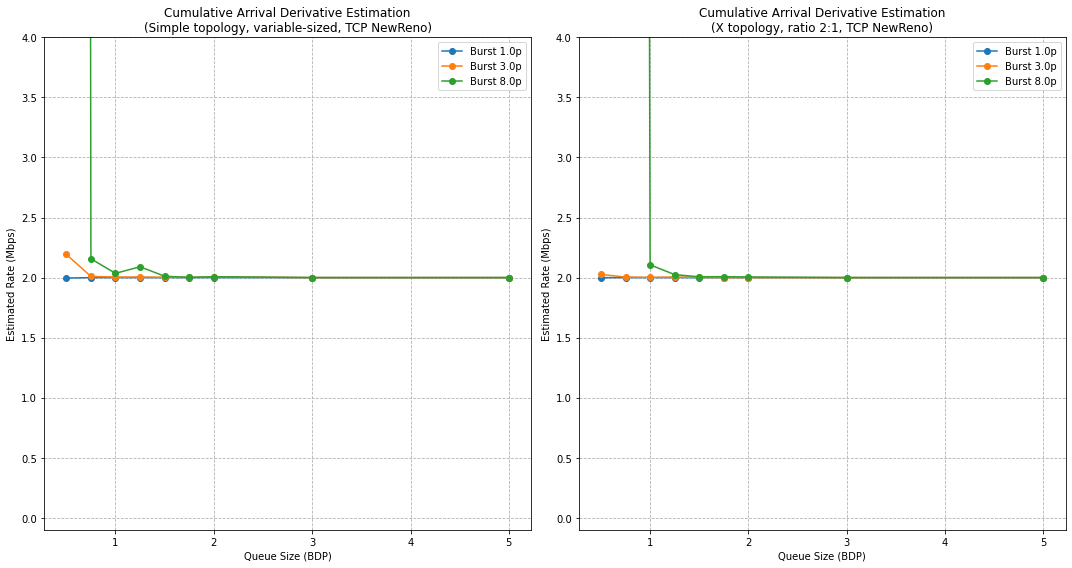

In [70]:
dfs = [
    df_reno_cum_var,
    df_reno_cum_xtopo_20
]

titles = [
    'Cumulative Arrival Derivative Estimation\n(Simple topology, variable-sized, TCP NewReno)',
    'Cumulative Arrival Derivative Estimation\n(X topology, ratio 2:1, TCP NewReno)',
]

multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, nrows=1, ncols=2, figsize=(15,8), log=False,save_path="figures/estimated_rate_cumulative_reno.png")

### CWND

Figure saved to: figures/estimated_rate_cwnd_reno.png


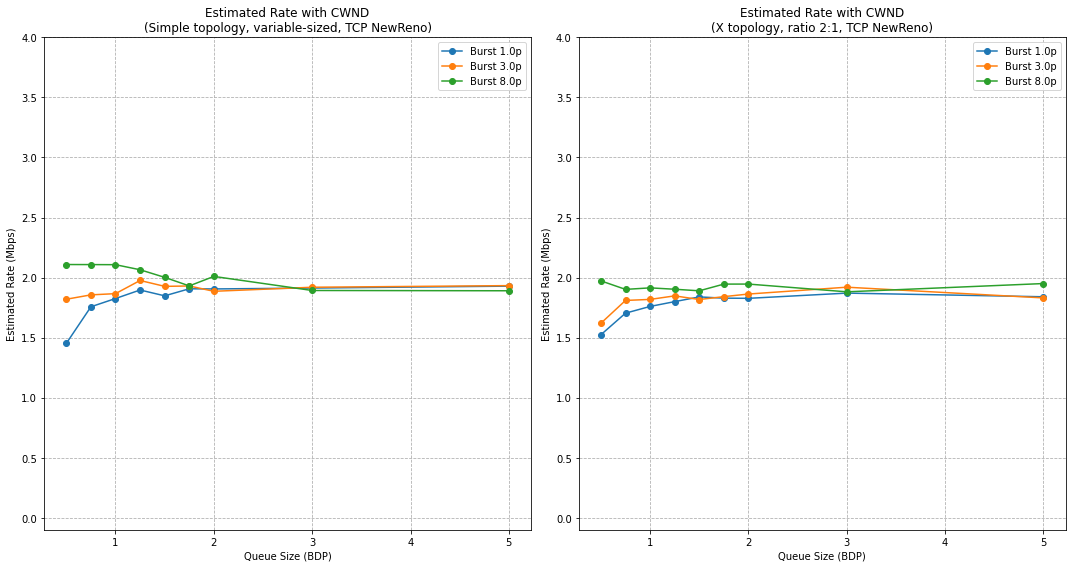

In [71]:
file = "data/results_reno-complex-shaping_CWND.csv"
df_reno_cwnd_var = pd.read_csv(file)
df_reno_cwnd_var = clean_colums(df_reno_cwnd_var)
df_reno_cwnd_var = df_reno_cwnd_var[df_reno_cwnd_var['queue_size'] <= 5]
df_reno_cwnd_var = df_reno_cwnd_var[df_reno_cwnd_var['queue_size'] >= 0.5]

file = "data/results_reno-xtopo_CWND.csv"
df_reno_cwnd_xtopo_20 = pd.read_csv(file)
df_reno_cwnd_xtopo_20 = clean_colums(df_reno_cwnd_xtopo_20, xtopo=True)
df_reno_cwnd_xtopo_20 = df_reno_cwnd_xtopo_20[df_reno_cwnd_xtopo_20['queue_size'] >= 0.5]
df_reno_cwnd_xtopo_20 = df_reno_cwnd_xtopo_20[df_reno_cwnd_xtopo_20['queue_size'] <= 5]

dfs = [
    df_reno_cwnd_var,
    df_reno_cwnd_xtopo_20
]

titles = [
    'Estimated Rate with CWND\n(Simple topology, variable-sized, TCP NewReno)',
    'Estimated Rate with CWND\n(X topology, ratio 2:1, TCP NewReno)',
]

multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, nrows=1, ncols=2, figsize=(15,8), log=False,save_path="figures/estimated_rate_cwnd_reno.png")

### Google

Figure saved to: figures/estimated_rate_google_reno.png


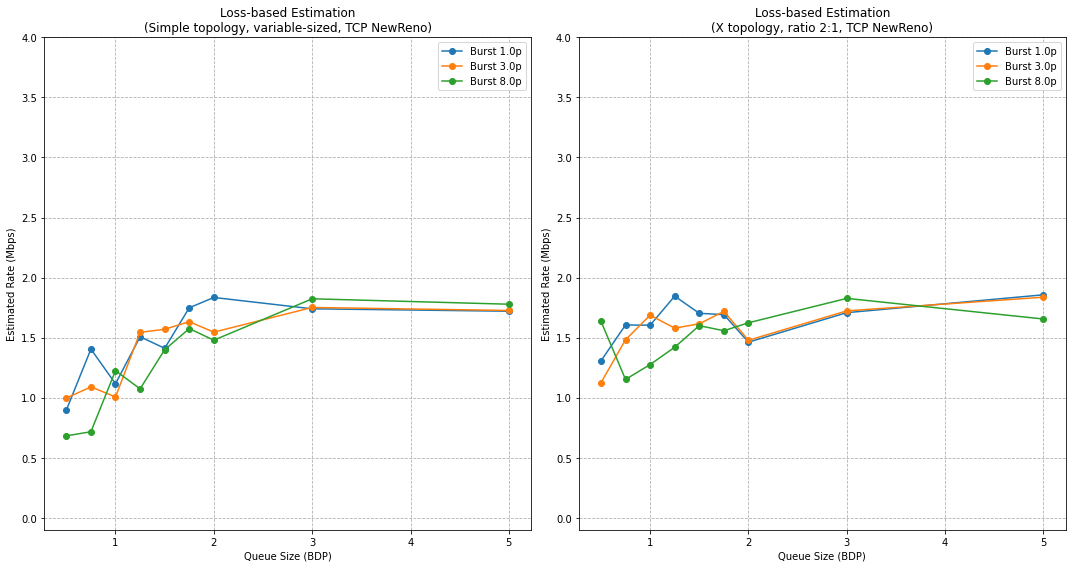

In [72]:
file = "data/results_reno-complex-shaping_GOOGLE.csv"
df_reno_google_var = pd.read_csv(file)
df_reno_google_var = clean_colums(df_reno_google_var)
df_reno_google_var = df_reno_google_var[df_reno_google_var['queue_size'] <= 5]
df_reno_google_var = df_reno_google_var[df_reno_google_var['queue_size'] >= 0.5]

file = "data/results_reno-xtopo_GOOGLE.csv"
df_reno_google_xtopo_20 = pd.read_csv(file)
df_reno_google_xtopo_20 = clean_colums(df_reno_google_xtopo_20, xtopo=True)
df_reno_google_xtopo_20 = df_reno_google_xtopo_20[df_reno_google_xtopo_20['queue_size'] >= 0.5]
df_reno_google_xtopo_20 = df_reno_google_xtopo_20[df_reno_google_xtopo_20['queue_size'] <= 5]

dfs = [
    df_reno_google_var,
    df_reno_google_xtopo_20
]

titles = [
    'Loss-based Estimation\n(Simple topology, variable-sized, TCP NewReno)',
    'Loss-based Estimation\n(X topology, ratio 2:1, TCP NewReno)',
]

multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, nrows=1, ncols=2, figsize=(15,8), log=False,save_path="figures/estimated_rate_google_reno.png")

### Goodput

Figure saved to: figures/estimated_rate_goodput_reno.png


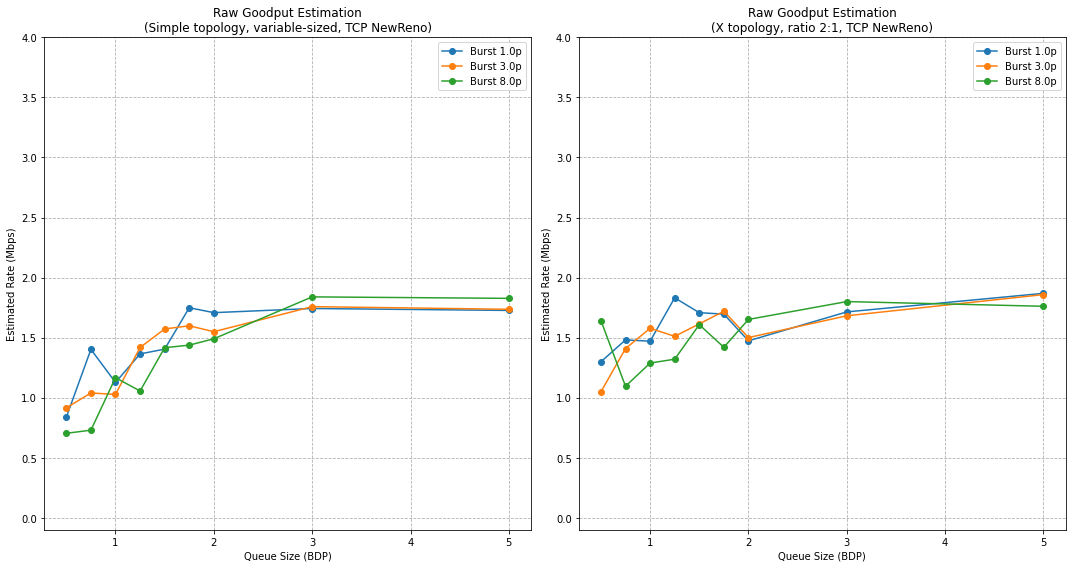

In [73]:
file = "data/results_reno-complex-shaping_GOOGLE.csv"
df_reno_google_var = pd.read_csv(file)
df_reno_google_var = clean_colums(df_reno_google_var)
df_reno_google_var = df_reno_google_var[df_reno_google_var['queue_size'] <= 5]
df_reno_google_var = df_reno_google_var[df_reno_google_var['queue_size'] >= 0.5]

file = "data/results_reno-xtopo_GOOGLE.csv"
df_reno_google_xtopo_20 = pd.read_csv(file)
df_reno_google_xtopo_20 = clean_colums(df_reno_google_xtopo_20, xtopo=True)
df_reno_google_xtopo_20 = df_reno_google_xtopo_20[df_reno_google_xtopo_20['queue_size'] >= 0.5]
df_reno_google_xtopo_20 = df_reno_google_xtopo_20[df_reno_google_xtopo_20['queue_size'] <= 5]

dfs = [
    df_reno_google_var,
    df_reno_google_xtopo_20
]

titles = [
    'Raw Goodput Estimation\n(Simple topology, variable-sized, TCP NewReno)',
    'Raw Goodput Estimation\n(X topology, ratio 2:1, TCP NewReno)',
]

multiplot_throughput(dfs, titles, y_min=-0.1, y_max=4, nrows=1, ncols=2, figsize=(15,8), log=False,save_path="figures/estimated_rate_goodput_reno.png")

### Throughput sampling

Figure saved to: figures/estimated_rate_tx_sample_reno.png


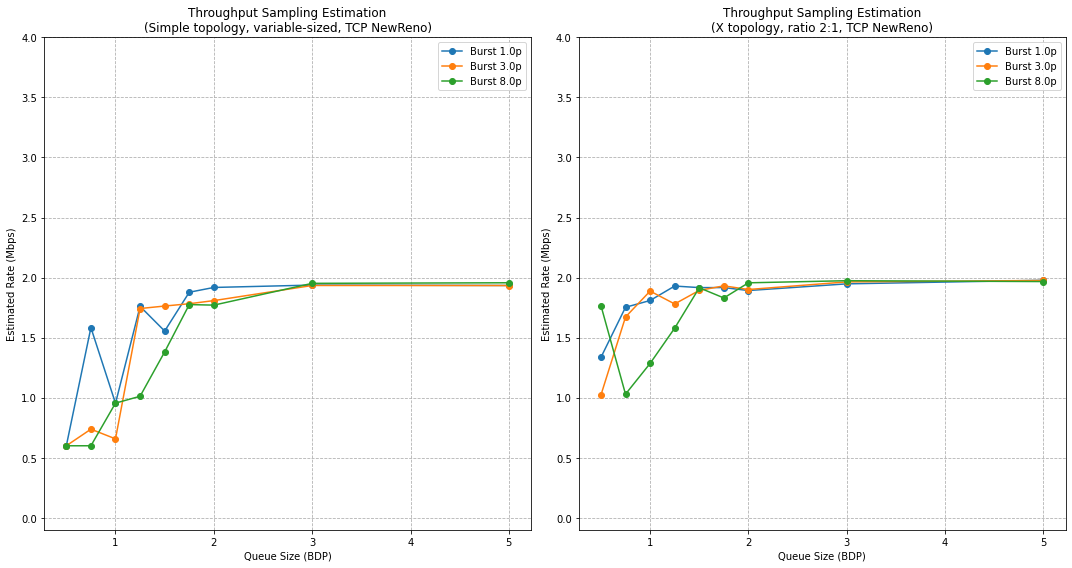

In [74]:
file = "data/results_reno-complex-shaping_TX_SAMPLE.csv"
df_reno_txsample_var = pd.read_csv(file)
df_reno_txsample_var = clean_colums(df_reno_txsample_var)
df_reno_txsample_var = df_reno_txsample_var[df_reno_txsample_var['queue_size'] <= 5]
df_reno_txsample_var = df_reno_txsample_var[df_reno_txsample_var['queue_size'] >= 0.5]

file = "data/results_reno-xtopo_TX_SAMPLE.csv"
df_reno_txsample_xtopo_20 = pd.read_csv(file)
df_reno_txsample_xtopo_20 = clean_colums(df_reno_txsample_xtopo_20, xtopo=True)
df_reno_txsample_xtopo_20 = df_reno_txsample_xtopo_20[df_reno_txsample_xtopo_20['queue_size'] >= 0.5]
df_reno_txsample_xtopo_20 = df_reno_txsample_xtopo_20[df_reno_txsample_xtopo_20['queue_size'] <= 5]

dfs = [
    df_reno_txsample_var,
    df_reno_txsample_xtopo_20
]

titles = [
    'Throughput Sampling Estimation\n(Simple topology, variable-sized, TCP NewReno)',
    'Throughput Sampling Estimation\n(X topology, ratio 2:1, TCP NewReno)',
]

multiplot_estimated_rate(dfs, titles, y_min=-0.1, y_max=4, nrows=1, ncols=2, figsize=(15,8), log=False,save_path="figures/estimated_rate_tx_sample_reno.png")